### Anomaly Detection with ORACLE

In [1]:
# !pip install numpy pandas matplotlib networkx polars tqdm astropy tf_keras tensorflow dataframe_image==0.2.5
# !pip install jupyter
# uncomment line above if necessary
import os
import pickle
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from collections import OrderedDict
from taxonomy import get_classification_labels, get_astrophysical_class, plot_colored_tree
import tf_keras as keras
import tensorflow as tf
import itertools
os.environ["TF_USE_LEGACY_KERAS"] = "1"

**Reading in Parquet files using Polars**

In [ ]:
static_feature_list = ['MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']

In [ ]:
train_path = "./../../train_parquet-001.parquet"
# test_path = "./../../test_parquet-002.parquet"
train_parquet = pl.read_parquet(train_path)
train_parquet.columns

In [ ]:
train_parquet['PEAKMJD']

In [ ]:
# def get_class_info(parquet):
#     assert parquet.shape[0] > 1
#     classes = []
#     snids = []
#     for row in range(parquet.shape[0]):
#         classes.append(parquet[row]["ELASTICC_class"].to_numpy()[0])
#         snids.append(parquet[row]["SNID"].to_numpy()[0])

#     return classes, snids

# classes, snids = get_class_info(train_parquet.head())
# print(list(zip(classes, snids)))

The following `LSST_Source()` class creates an object for each individual lightcurve that computes and stores the flux values (and other time-series data), as well as the static features associated with the lightcurve.

The `LSSTSourceDataSet()` class then stores the collection of `LSST_Source` objects from all the lightcurves in the Polars DataFrame.

In [2]:
import matplotlib.patches as mpatches

class LSST_Source:

    # List of time series features actually stored in the instance of the class.
    time_series_features = ['MJD', 'BAND', 'PHOTFLAG', 'FLUXCAL', 'FLUXCALERR']

    # List of other features actually stored in the instance of the class.
    other_features = ['RA', 'DEC', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'VPEC', 'VPEC_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_DDLR', 'HOSTGAL_LOGMASS', 'HOSTGAL_LOGMASS_ERR', 'HOSTGAL_LOGSFR', 'HOSTGAL_LOGSFR_ERR', 'HOSTGAL_LOGsSFR', 'HOSTGAL_LOGsSFR_ERR', 'HOSTGAL_COLOR', 'HOSTGAL_COLOR_ERR', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r', 'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y', 'PEAKMJD']

    # Additional features computed based on time_series_features and other_features mentioned in SNANA fits.
    custom_engineered_features = ['MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']

    # Get the mean wavelengths for each filter and then convert to micro meters
    pb_wavelengths = {
        'u': (320 + 400) / (2 * 1000),
        'g': (400 + 552) / (2 * 1000),
        'r': (552 + 691) / (2 * 1000),
        'i': (691 + 818) / (2 * 1000),
        'z': (818 + 922) / (2 * 1000),
        'Y': (950 + 1080) / (2 * 1000),
    }

    # Pass band to color dict
    colors = OrderedDict({
        'u': 'blue',
        'g': 'green',
        'r': 'red',
        'i': 'teal',
        'z': 'orange',
        'Y': 'purple',
    })

    # 6 broadband filters used in LSST.
    LSST_bands = list(colors.keys())

    # Coordinates for LSST's 4 selected deep drilling fields. (Reference: https://www.lsst.org/scientists/survey-design/ddf)
    LSST_DDF = {
        'ELAIS_S1': SkyCoord(l=311.30 * u.deg, b=-72.90 * u.deg, frame='galactic'),
        'XMM-LSS': SkyCoord(l=171.20 * u.deg, b=-58.77 * u.deg, frame='galactic'),
        'Extended_Chandra_Deep_Field-South': SkyCoord(l=224.07 * u.deg, b=-54.47 * u.deg, frame='galactic'),
        'COSMOS': SkyCoord(l=236.83 * u.deg, b=42.09 * u.deg, frame='galactic'),
    }


    # Threshold values

    # MW_plane_flag is set to one if |self.b| <= b_threshold. Indicative of weather the object is in the galactic plane.
    b_threshold = 15 

    # Flux scaling value
    flux_scaling_const = 1000

    # Radius of the deep drilling field for LSST, in degrees.
    ddf_separation_radius_threshold = 3.5 / 2


    def __init__(self, parquet_row) -> None:
        """Create an LSST_Source object to store both photometric and host galaxy data from the Elasticc simulations.

        Args:
            parquet_row (_type_): A row from the polars data frame that was generated from the Elasticc FITS files using fits_to_parquet.py
            class_label (str): The Elasticc class label for this LSST_Source object.
        """

        # Set all the class attributes
        setattr(self, 'ELASTICC_class', parquet_row['ELASTICC_class'].to_numpy()[0])
        setattr(self, 'SNID', parquet_row['SNID'].to_numpy()[0])
        setattr(self, 'astrophysical_class', get_astrophysical_class(self.ELASTICC_class))

        for key in parquet_row.columns:
            if key in self.other_features:
                setattr(self, key, parquet_row[key].to_numpy()[0])
            elif key in self.time_series_features:
                setattr(self, key, parquet_row[key][0].to_numpy())

        # Run processing code on the light curves
        self.process_lightcurve()

        # Computer additional features
        self.compute_custom_features()

    
    def process_lightcurve(self) -> None:
        """Process the flux information with phot flags. Processing is done using the following steps:
        1. Remove saturations.
        Finally, all the time series data is modified to conform to the steps mentioned above.
        """

        # Remove saturations from the light curves
        saturation_mask =  (self.PHOTFLAG & 1024) == 0 

        # Alter time series data to remove saturations
        for time_series_feature in self.time_series_features:
            setattr(self, time_series_feature, getattr(self, time_series_feature)[saturation_mask])
        
    def compute_custom_features(self) -> None:

        source_coord = SkyCoord(ra = self.RA * u.deg, dec=self.DEC * u.deg)

        # Check if the object is close to the galactic plane of the milky way
        if abs(source_coord.galactic.b.degree) < self.b_threshold: 
            self.MW_plane_flag = 1
        else:
            self.MW_plane_flag = 0
        
        # Check if the object is in one of 4 LSST DDF's and set flags appropriately
        for key in self.LSST_DDF:

            # Separation from field center
            separation = source_coord.separation(self.LSST_DDF[key]).degree

            if separation < self.ddf_separation_radius_threshold:
                setattr(self, f'{key}_flag', 1)
            else:
                setattr(self, f'{key}_flag', 0)

        pass


    def plot_flux_curve(self) -> None:
        """Plot the SNANA calibrated flux vs time plot for all the data in the processed time series. All detections are marked with a star while non detections are marked with dots. Observations are color codded by their passband. This function is fundamentally a visualization tool and is not intended for making plots for papers.
        """

        # Colorize the data
        c = [self.colors[band] for band in self.BAND]
        patches = [mpatches.Patch(color=self.colors[band], label=band, linewidth=1) for band in self.colors]
        fmts = np.where((self.PHOTFLAG & 4096) != 0, '*', '.')

        # Plot flux time series
        for i in range(len(self.MJD)):
            plt.errorbar(x=self.MJD[i], y=self.FLUXCAL[i], yerr=self.FLUXCALERR[i], color=c[i], fmt=fmts[i], markersize = '10')
            # if c[i] == 'red':
                # plt.errorbar(x=self.MJD[i], y=self.FLUXCAL[i], yerr=self.FLUXCALERR[i], color=c[i], fmt=fmts[i], markersize = '10')

        # Labels
        plt.title(f"SNID: {self.SNID} | CLASS: {self.ELASTICC_class}")
        plt.xlabel('Time (MJD)')
        plt.ylabel('Calibrated Flux')
        plt.legend(handles=patches)

        plt.show()

    def get_classification_labels(self):
        """Get the classification labels (hierarchical) for this LSST Source object in the Taxonomy tree.

        Returns:
            (tree_nodes, numerical_labels): A tuple containing two list like objects. The first object contains the ordering of the nodes. The second list contains the labels themselves (0 when the object does not belong to the class and 1 when it does). The labels in the second object correspond to the nodes in the first object.
        """
        return get_classification_labels(self.astrophysical_class)
    
    def plot_classification_tree(self):
        """Plot the classification tree (based on our taxonomy) for this LSST Source object.
        """

        node, labels = self.get_classification_labels()
        plot_colored_tree(labels)


    def get_event_table(self):

        # Dataframe for time series data
        table = Table()

        # Find time since last observation
        time_since_first_obs = self.MJD - self.MJD[0]
        table['scaled_time_since_first_obs'] = time_since_first_obs / 100

        # 1 if it was a detection, zero otherwise
        table['detection_flag'] = np.where((self.PHOTFLAG & 4096 != 0), 1, 0)

        # Transform flux cal and flux cal err to more manageable values (more consistent order of magnitude)
        table['scaled_FLUXCAL'] = self.FLUXCAL / self.flux_scaling_const
        table['scaled_FLUXCALERR'] = self.FLUXCALERR / self.flux_scaling_const

        # One hot encoding for the pass band
        table['band_label'] = [self.pb_wavelengths[pb] for pb in self.BAND]

        # Consistency check
        assert len(table) == len(self.MJD), "Length of time series tensor does not match the number of mjd values."

        # Array for static features
        feature_static = OrderedDict()
        for other_feature in self.other_features:
            feature_static[other_feature] = getattr(self, other_feature)

        for feature in self.custom_engineered_features:
            feature_static[feature] = getattr(self, feature)

        # Array for computed static features
        table.meta = feature_static
        return table

    def get_custom_table(self):
        table = Table()
        table['MJD'] = self.MJD
        table['detection_flag'] = np.where((self.PHOTFLAG & 4096 != 0), 1, 0)
        table['flux'] = self.FLUXCAL
        table['flux_err'] = self.FLUXCALERR
        table['band'] = self.BAND

        peakmjd = self.PEAKMJD
        
        return table, peakmjd

    def __str__(self) -> str:

        to_return = str(vars(self))
        return to_return

In [3]:
class LSSTSourceDataSet():


    def __init__(self, path):
        """
        Arguments:
            path (string): Parquet file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        print(f'Loading parquet dataset: {path}', flush=True)

        self.path = path
        self.parquet = pl.read_parquet(path)
        self.num_sample = self.parquet.shape[0]

        print(f"Number of sources: {self.num_sample}")

    def get_len(self):

        return self.num_sample

    def get_item(self, idx):
        
        row = self.parquet[idx]
        source = LSST_Source(row)
        table = source.get_event_table()

        astrophysical_class = get_astrophysical_class(source.ELASTICC_class)
        _, class_labels = get_classification_labels(astrophysical_class)
        class_labels = np.array(class_labels)
        snid = source.SNID

        return source, class_labels, snid

    def get_item_from_snid(self, snid):
        row = self.parquet.filter(pl.col('SNID') == snid)
        # row = self.pandas.loc[self.pandas['SNID'] == snid]
        # print(row)
        source = LSST_Source(row)
        table = source.get_event_table()

        astrophysical_class = get_astrophysical_class(source.ELASTICC_class)
        _, class_labels = get_classification_labels(astrophysical_class)
        class_labels = np.array(class_labels)
        snid = source.SNID

        return source, class_labels, snid, astrophysical_class
    
    def get_dimensions(self):

        idx = 0
        source, class_labels = self.get_item(idx)
        table = source.get_event_table()

        ts_np = table.to_pandas().to_numpy()
        static_np = np.array(list(table.meta.values()))

        dims = {
            'ts': ts_np.shape[1],
            'static': static_np.shape[0],
            'labels': class_labels.shape[0]
        }

        return dims
    
    def get_labels(self):

        ELASTICC_labels = self.parquet['ELASTICC_class']
        astrophysical_labels = []

        for idx in range(self.num_sample):

            elasticc_class = ELASTICC_labels[idx]
            astrophysical_class = get_astrophysical_class(elasticc_class)
            astrophysical_labels.append(astrophysical_class)
        
        return astrophysical_labels

In [ ]:
# printing out important lightcurve features/information from the LSST_Source objects
train = LSSTSourceDataSet("./../../train_parquet-001.parquet")
source, class_labels, snid = train.get_item(0)
table = source.get_event_table()
# print(table[np.where(table['detection_flag'] == 1)])
# table.write(f'flux_{}')
# print(table.meta)

Loading parquet dataset: ./../../train_parquet-001.parquet


In [ ]:
train = LSSTSourceDataSet("./../../train_parquet-001.parquet")
source, class_labels, snid = train.get_item(0)
table2, peakmjd = source.get_custom_table()
table2, peakmjd

In [ ]:
snids = [58373175, 41513701, 68855884, 38352249, 54732684, 73817174, 57303432]

for snid in snids:
    source, class_labels, snid, class_label = train.get_item_from_snid(snid)
    table = source.get_event_table()
    r_band = np.array(table['scaled_FLUXCAL'][np.where(table['band_label'] == LSST_Source.pb_wavelengths['r'])]) * LSST_Source.flux_scaling_const
    # source.plot_flux_curve()
    # np.save(f'lc_{snid}.npy', r_band)
    # class_label
    table.write(f'flux_{snid}_{class_label}.csv', overwrite=True)

In [ ]:
# from astropy.io import ascii
# data = ascii.read('flux_73817174_CART.csv')
# data

snids = [58373175, 41513701, 68855884, 38352249, 54732684, 73817174, 57303432]

for snid in snids:
    source, class_labels, snid, class_label = train.get_item_from_snid(snid)
    table = source.get_event_table()
    table2 = source.get_custom_table()
    table2.write(f'raw_flux_{snid}_{class_label}.csv', overwrite=True)

In [ ]:
source, labels, snid, class_label = train.get_item_from_snid(58373175)
table = source.get_event_table()
print(np.array(table['scaled_FLUXCAL'][np.where(table['band_label'] == LSST_Source.pb_wavelengths['r'])]) * LSST_Source.flux_scaling_const)
source.plot_flux_curve()

In [ ]:
# [table2['MJD'][np.where(table2['band'] == 'r')]]
n = 10
days = np.squeeze(np.multiply([table['scaled_time_since_first_obs'][np.where(table['band_label'] == LSST_Source.pb_wavelengths['r'])]], 100))[:n]
r_bands = np.squeeze(np.array([table['scaled_FLUXCAL'][np.where(table['band_label'] == LSST_Source.pb_wavelengths['r'])]]))[:n]
print(list(zip(days, r_bands)))
table[:10]

Preparing the NumPy arrays with the stored lightcurve features (and then saving them in Pickle files so that we don't need to reprocess them every time we want to run the model, because the processing is super time-consuming).

In [94]:
# ### TAKES A WHILE TO RUN
from dataloader import get_static_features

def save(save_path , obj):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)

# X_ts = []
unscaled_X_ts = []
# X_static = []
# Y = []
# peakmjds = []
# astrophysical_classes = []
# elasticc_classes = []
# lengths = []

print(type(get_static_features))

# train = LSSTSourceDataSet("./../../train_parquet-001.parquet")

for i in tqdm(range(int(train.get_len() / 2) + 1, train.get_len()), disable=False):

    source, labels, snid = train.get_item(i)
    table2, peakmjd = source.get_custom_table()

    # meta_data = table.meta
    # ts_data = pd.DataFrame(np.array(table)) # astropy table to pandas dataframe

    # # Append data for ML
    # X_ts.append(ts_data)
    # X_static.append(meta_data)
    # Y.append(labels)
    # peakmjds.append(peakmjd)
    unscaled_X_ts.append(table2.as_array())

    # # Append other useful data
    # astrophysical_classes.append(source.astrophysical_class)
    # elasticc_classes.append(source.ELASTICC_class)
    # lengths.append(ts_data.shape[0])

# for i in tqdm(range(len(X_static))):        
#     X_static[i] = get_static_features(X_static[i])

print("\nDumping to pickle...")

# Make a directory and save the data
os.makedirs("pickles", exist_ok=True)       

# save(f"{"pickles"}/y.pkl", Y)
# save(f"{"pickles"}/x_ts.pkl", X_ts)
# save(f"{"pickles"}/x_static.pkl", X_static)
# save(f"{"pickles"}/a_labels.pkl", astrophysical_classes)
# save(f"{"pickles"}/e_label.pkl", elasticc_classes)
# save(f"{"pickles"}/lengths.pkl", lengths)
# save(f"pickles/peakmjds.pkl", peakmjds)
save('pickles/unscaled_x_ts2.pkl', unscaled_X_ts)

<class 'function'>


100%|██████████| 540806/540806 [1:10:35<00:00, 127.70it/s]



Dumping to pickle...


In [5]:
unscaled_X_ts1 = load('pickles/unscaled_x_ts.pkl')
unscaled_X_ts2 = load('pickles/unscaled_x_ts2.pkl')

len(unscaled_X_ts1 + unscaled_X_ts2)

1081614

Loading the saved pickle files and unpacking them into arrays

In [4]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [6]:
from taxonomy import get_taxonomy_tree
class_count = 10
ts_length = 500
ts_flag_value = 0.

model = keras.models.load_model(f"models/lsst_alpha_0.5/best_model.h5", compile=False)

tree = get_taxonomy_tree()
X_ts = load(f"{"pickles"}/x_ts.pkl")
X_static = load(f"{"pickles"}/x_static.pkl")
Y = load(f"{"pickles"}/y.pkl")
astrophysical_classes = load(f"{"pickles"}/a_labels.pkl")
peakmjds = load('pickles/peakmjds.pkl')

In [89]:
unscaled_X_ts = load('pickles/unscaled_x_ts.pkl')

In [9]:
len(unscaled_X_ts)

NameError: name 'unscaled_X_ts' is not defined

**Running the model**

Selecting the correct static and time-series features from the dataset and running the model with these feature values as input

In [ ]:
from interpret_results import get_conditional_probabilites
from taxonomy import get_taxonomy_tree

static_features = ['MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']
tree = get_taxonomy_tree()

class_probs = []
class_count = 10

for j, c in enumerate(np.unique(astrophysical_classes)): # iterates over each leaf node class

    # gets the correct set of time series and static features from every lightcurve for that specific class by matching them up using the correct index
    idx = list(np.where(np.array(astrophysical_classes) == c)[0])[:class_count]
    X_ts_class = [X_ts[i] for i in idx]
    X_static_class = [X_static[i] for i in idx]
    Y_class = [Y[i] for i in idx]

    for i in tqdm(range(5)): # iterates through the first five lightcurves from each astrophysical class

        # gets the individual features for that lightcurve
        table = X_ts_class[i]
        static = X_static_class[i]
        target = Y_class[i]
        
        tables = []
        statics = []
        statics_info = []
        for k in range(1, table.to_numpy().shape[0] + 1):
            tables = table.to_numpy()[:k, :]
            statics_info.append(static)
            # statics.append(list(static.values()))

        tables = np.expand_dims(tables, axis=0)
        statics.append(static)

        # for k in range(1, table.to_numpy().shape[0] + 1):
            # tables.append(table.to_numpy()[:k, :])
            # statics.append(static)
        
        # since we're working with partial lightcurve data, not all curves will have the same length, so this function pads the input time series data to all have the same length
        tables = tf.keras.utils.pad_sequences(tables, maxlen=ts_length,  dtype='float32', padding='post', value=ts_flag_value)
        
        # statics = np.squeeze(statics)

        true_class_idx = np.argmax(target[-19:])

        tables = np.asarray(tables).astype(np.float32)
        statics = np.asarray(statics).astype(np.float32)
        
        logits = model.predict([tables, statics], verbose=0).astype(np.float64)
        _, pseudo_conditional_probabilities = get_conditional_probabilites(logits, tree)
        class_probs.append([pseudo_conditional_probabilities, true_class_idx])
        # print(statics)

In [ ]:
# from interpret_results import get_conditional_probabilites
# from taxonomy import get_taxonomy_tree

# static_features = ['MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']
# tree = get_taxonomy_tree()

# class_probs = []

# for j, c in enumerate(np.unique(astrophysical_classes)): # iterates over each leaf node class

#     # gets the correct set of time series and static features from every lightcurve for that specific class by matching them up using the correct index
#     idx = list(np.where(np.array(astrophysical_classes) == c)[0])[:class_count]
#     X_ts_class = [X_ts[i] for i in idx]
#     X_static_class = [X_static[i] for i in idx]
#     Y_class = [Y[i] for i in idx]

#     for i in range(5): # iterates through the first five lightcurves from each astrophysical class

#         # gets the individual features for that lightcurve
#         table = X_ts_class[i]
#         static = X_static_class[i]
#         target = Y_class[i]

#         tables = []
#         statics = []
#         statics_info = []
#         for k in range(1, table.to_numpy().shape[0] + 1):
#             tables = table.to_numpy()[:k, :]
#             statics_info.append(static)
#             statics.append(list(static.values()))

#         tables = np.expand_dims(tables, axis=0)
#         statics.append([static[feature] for feature in static_features])

#         # for k in range(1, table.to_numpy().shape[0] + 1):
#             # tables.append(table.to_numpy()[:k, :])
#             # statics.append(static)
        
#         # since we're working with partial lightcurve data, not all curves will have the same length, so this function pads the input time series data to all have the same length
#         tables = tf.keras.utils.pad_sequences(tables, maxlen=ts_length,  dtype='float32', padding='post', value=ts_flag_value)
        
#         # statics = np.squeeze(statics)

#         true_class_idx = np.argmax(target[-19:])

#         tables = np.asarray(tables).astype(np.float32)
#         statics = np.asarray(statics).astype(np.float32)
        
#         logits = model.predict([tables, statics], verbose=0).astype(np.float64)
#         _, pseudo_conditional_probabilities = get_conditional_probabilites(logits, tree)
#         class_probs.append([pseudo_conditional_probabilities, true_class_idx])
#         # print(statics)

In [ ]:
import networkx as nx
from taxonomy import source_node_label
level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())

leaf_nodes = level_order_nodes[-19:]
true_classes = [class_probs[i][1] for i in range(len(class_probs))]
true_class_names = []
for class_idx in true_classes:
    true_class_names.append(leaf_nodes[class_idx])

# print(f'{len(class_probs), len(true_class_names)}')

In [ ]:
len(class_probs[0][0][0])

In [ ]:
from taxonomy import source_node_label

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

class_df = pd.DataFrame(true_class_names, columns=['True Class:'])
indiv_probs = [np.squeeze(class_probs[index][0]) for index in range(len(class_probs))]
class_probs_df = pd.DataFrame(indiv_probs)
df = pd.concat([class_df, class_probs_df], axis=1, ignore_index=True)
columns = level_order_nodes.copy()
columns.insert(0, 'True Class:')
df.columns = columns
df

In [ ]:
indiv_probs

In [ ]:
results = df
# anomaly_labels = results[['SNIb/c', 'SNI91bg', 'KN', 'Dwarf Novae', 'uLens', 'M-dwarf Flare', 'SLSN', 'TDE', 'ILOT', 'CART', 'PISN']]
# non_anomaly_labels = results[['SNIa', 'SNII', 'Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB', 'AGN', 'SNIax']]
anomaly_labels = results[['KN', 'uLens', 'SLSN', 'PISN', 'TDE', 'CART', 'ILOT']]
non_anomaly_labels = results[['Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB', 'SNIa', 'SNIax', 'SNIb/c', 'SNI91bg', 'SNII', 'M-dwarf Flare', 'Dwarf Novae', 'AGN']]
anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in anomaly_labels.iterrows()]
non_anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in non_anomaly_labels.iterrows()]
anomaly_detections = list(enumerate(zip(anomaly_preds, non_anomaly_preds)))

leaf_labels = np.array(level_order_nodes)[-19:]
pred_labels = [leaf_labels[i] for i in np.argmax(np.array(indiv_probs)[:, -19:], axis=1)]

anomaly_detections[:10]

In [ ]:
anomaly = pd.DataFrame({'Anomaly Probability': [anomaly_detections[row][1][0] for row in range(len(anomaly_detections))]})
not_anomaly = pd.DataFrame({'Not Anomaly Probability': [anomaly_detections[row][1][1] for row in range(len(anomaly_detections))]})

anomaly.reset_index(drop=True, inplace=True)
not_anomaly.reset_index(drop=True, inplace=True)
preds_df = pd.concat([class_df, anomaly, not_anomaly.set_axis(anomaly.index)], axis=1)
preds_df

In [ ]:
labels = [class_probs[i][1] for i in range(len(class_probs))]
anomaly_map = [
    0.0, # AGN - not anomaly
    0.0, # SNIa - not anomaly
    0.0, # SNIb/c - not anomaly
    0.0, # SNIax - not anomaly
    1.0, # SNI91bg - anomaly
    0.0, # SNII - not anomaly
    1.0, # KN - anomaly
    0.0, # Dwarf Novae - not anomaly
    1.0, # uLens - anomaly
    0.0, # M-dwarf Flare - not anomaly
    1.0, # SLSN - anomaly
    1.0, # TDE - anomaly
    1.0, # ILOT - anomaly
    1.0, # CART - anomaly
    1.0, # PISN - anomaly
    0.0, # Cepheid - not anomaly
    0.0, # RR Lyrae - not anomaly
    0.0, # Delta Scuti - not anomaly
    0.0  # EB - not anomaly
]

y_true = [[anomaly_map[label], 1.0 - anomaly_map[label]] for label in labels]
anomaly = np.array([anomaly_detections[row][1][0] for row in range(len(anomaly_detections))])
non_anomaly = np.array([anomaly_detections[row][1][1] for row in range(len(anomaly_detections))])
y_pred = np.stack((anomaly, non_anomaly), axis=1)
y_true

In [ ]:
from sklearn import metrics

true = [np.argmax(y_true[i]) for i in range(len(y_true))]
# pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
pred = [0 if element > 0.7 else 1 for element in np.transpose(y_pred)[0]]
# pred = [element for element in y_pred]

cm = metrics.confusion_matrix(true, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Not Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Anomaly Detection with ORACLE', fontsize=20.0)
plt.savefig('current_cm.png')
plt.show()

In [18]:
# from taxonomy import source_node_label, get_taxonomy_tree

# def determine_anomalies(class_probs, tree, purity_threshold=0.7):
#     # takes model output and converts to binary anomaly detection/non-detection
#     level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())
#     leaf_nodes = level_order_nodes[-19:]

#     print(np.array(class_probs[0]).shape)
#     # indiv_probs = [class_probs[0][index] for index in range(len(class_probs))]
#     indiv_probs = class_probs[0]
#     class_probs_df = pd.DataFrame(indiv_probs)

#     columns = level_order_nodes.copy()
#     class_probs_df.columns = columns
    
#     # groups nodes for anomaly detection
#     anomaly_labels = class_probs_df[['KN', 'uLens', 'SLSN', 'PISN', 'TDE', 'CART', 'ILOT']]
#     non_anomaly_labels = class_probs_df[['Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB', 'SNIa', 'SNIax', 'SNIb/c', 'SNI91bg', 'SNII', 'M-dwarf Flare', 'Dwarf Novae', 'AGN']]
#     anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in anomaly_labels.iterrows()]
#     non_anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in non_anomaly_labels.iterrows()]
#     anomaly_detections = list(enumerate(zip(anomaly_preds, non_anomaly_preds)))

#     # maps class labels to generate y_true for anomalies
#     # labels = [class_probs[i][1] for i in range(len(class_probs))]
#     labels = class_probs[1]
#     anomaly_map = [
#         0.0, # AGN - not anomaly
#         0.0, # SNIa - not anomaly
#         0.0, # SNIb/c - not anomaly
#         0.0, # SNIax - not anomaly
#         1.0, # SNI91bg - anomaly
#         0.0, # SNII - not anomaly
#         1.0, # KN - anomaly
#         0.0, # Dwarf Novae - not anomaly
#         1.0, # uLens - anomaly
#         0.0, # M-dwarf Flare - not anomaly
#         1.0, # SLSN - anomaly
#         1.0, # TDE - anomaly
#         1.0, # ILOT - anomaly
#         1.0, # CART - anomaly
#         1.0, # PISN - anomaly
#         0.0, # Cepheid - not anomaly
#         0.0, # RR Lyrae - not anomaly
#         0.0, # Delta Scuti - not anomaly
#         0.0  # EB - not anomaly
#     ]
#     y_true = [[anomaly_map[np.argmax(label)], 1.0 - anomaly_map[np.argmax(label)]] for label in labels]

#     # reformats anomaly detections to match y_true for metric calculation
#     anomaly = np.array([anomaly_detections[row][1][0] for row in range(len(anomaly_detections))])
#     non_anomaly = np.array([anomaly_detections[row][1][1] for row in range(len(anomaly_detections))])
#     y_pred = np.stack((anomaly, non_anomaly), axis=1)

#     # converts from one hot encoding to argmax representation for sklearn.metrics functions
#     true = [np.argmax(y_true[i]) for i in range(len(y_true))]
#     pred = [0 if element > purity_threshold else 1 for element in np.transpose(y_pred)[0]]

#     return true, pred

from taxonomy import source_node_label, get_taxonomy_tree

def determine_anomalies(class_probs, tree, purity_threshold=0.7):
    print(f'PURITY : {purity_threshold}')
    # takes model output and converts to binary anomaly detection/non-detection
    level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())
    leaf_nodes = level_order_nodes[-19:]

    print(np.array(class_probs[0]).shape)
    # indiv_probs = [class_probs[0][index] for index in range(len(class_probs))]
    indiv_probs = class_probs[0]
    class_probs_df = pd.DataFrame(indiv_probs)

    columns = level_order_nodes.copy()
    class_probs_df.columns = columns
    
    # groups nodes for anomaly detection
    anomaly_labels = class_probs_df[['KN', 'uLens', 'SLSN', 'PISN', 'TDE', 'CART', 'ILOT']]
    non_anomaly_labels = class_probs_df[['Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB', 'SNIa', 'SNIax', 'SNIb/c', 'SNI91bg', 'SNII', 'M-dwarf Flare', 'Dwarf Novae', 'AGN']]
    anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in anomaly_labels.iterrows()]
    non_anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in non_anomaly_labels.iterrows()]
    anomaly_detections = list(enumerate(zip(anomaly_preds, non_anomaly_preds)))

    # maps class labels to generate y_true for anomalies
    # labels = [class_probs[i][1] for i in range(len(class_probs))]
    labels = class_probs[1]
    anomaly_map = [
        0.0, # AGN - not anomaly
        0.0, # SNIa - not anomaly
        0.0, # SNIb/c - not anomaly
        0.0, # SNIax - not anomaly
        1.0, # SNI91bg - anomaly
        0.0, # SNII - not anomaly
        1.0, # KN - anomaly
        0.0, # Dwarf Novae - not anomaly
        1.0, # uLens - anomaly
        0.0, # M-dwarf Flare - not anomaly
        1.0, # SLSN - anomaly
        1.0, # TDE - anomaly
        1.0, # ILOT - anomaly
        1.0, # CART - anomaly
        1.0, # PISN - anomaly
        0.0, # Cepheid - not anomaly
        0.0, # RR Lyrae - not anomaly
        0.0, # Delta Scuti - not anomaly
        0.0  # EB - not anomaly
    ]
    y_true = [[anomaly_map[np.argmax(label)], 1.0 - anomaly_map[np.argmax(label)]] for label in labels]
    print(y_true[:10])

    # reformats anomaly detections to match y_true for metric calculation
    anomaly = np.array([anomaly_detections[row][1][0] for row in range(len(anomaly_detections))])
    non_anomaly = np.array([anomaly_detections[row][1][1] for row in range(len(anomaly_detections))])
    y_pred = np.stack((anomaly, non_anomaly), axis=1)

    # converts from one hot encoding to argmax representation for sklearn.metrics functions
    true = [np.argmax(y_true[i]) for i in range(len(y_true))]
    pred = [0 if element > purity_threshold else 1 for element in np.transpose(y_pred)[0]]

    return true, pred

In [19]:
from dataloader import augment_ts_length_to_days_since_trigger, get_ts_upto_days_since_trigger, get_augmented_data
from interpret_results import save_all_cf_and_rocs, save_leaf_cf_and_rocs, get_conditional_probabilites
from vizualizations import plot_confusion_matrix
import networkx as nx
import numpy as np
import pandas as pd
import gc

days = 2 ** np.array(range(11))
default_batch_size = 1024

def save(save_path , obj):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)

def run_day_wise_anomaly_detection_analysis(model, tree, model_dir, X_ts, X_static, Y, astrophysical_classes):
    
    all_predictions = []
    all_trues = []

    for d in days:

        print(f'Running inference for trigger + {d} days...')

        if not os.path.isdir(f'pickles/augmented/day{d}'):
            os.makedirs(f'./pickles/augmented/day{d}')
        
        # if d == 8 or not os.path.exists(f'pickles/augmented/day{d}/x1.pkl'):
        #     x1, x2, y_true, _ = augment_ts_length_to_days_since_trigger(X_ts, X_static, Y, astrophysical_classes, d)
            
        #     save(f"pickles/augmented/day{d}/x1.pkl", x1)
        #     save(f"pickles/augmented/day{d}/x2.pkl", x2)
        #     save(f"pickles/augmented/day{d}/y.pkl", y_true)
        # else:
        #     # print(f'Loading x, y values from disk for day {d}')
        #     gc.collect()
        #     x1 = load(f"pickles/augmented/day{d}/x1.pkl")
        #     x2 = load(f"pickles/augmented/day{d}/x2.pkl")
        #     y_true = load(f"pickles/augmented/day{d}/y.pkl")
        #     # print('Loaded!')
        
        # Run inference on these
        if not os.path.exists(f'pickles/augmented/day{d}/pred.pkl'):
            y_pred = model.predict([x1, x2], batch_size=default_batch_size)
            save(f"pickles/augmented/day{d}/pred.pkl", y_pred)
            print('Saved to disk!')
        else:
            print(f'Loading y_pred values from disk for day {d}')
            y_true = load(f"pickles/augmented/day{d}/y.pkl")
            y_pred = load(f'pickles/augmented/day{d}/pred.pkl')
            print('Loaded!')

        # Get the conditional probabilities
        _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)
        probs_with_labels = [pseudo_conditional_probabilities, y_true]

        if os.path.exists(f'pickles/augmented/day{d}/anomalies_true.pkl'):
            print(f'Detecting anomalies for day {d}')
            true, pred = determine_anomalies(probs_with_labels, tree)
            # save(f"pickles/augmented/day{d}/anomalies_true.pkl", true)
            # save(f'pickles/augmented/day{d}/anomalies_pred.pkl', pred)
            print('Saved to disk!')
        else:
            print(f'Loading anomaly values from disk for day {d}')
            true = load(f'pickles/augmented/day{d}/anomalies_true.pkl')
            pred = load(f'pickles/augmented/day{d}/anomalies_pred.pkl')
            print('Loaded!')

        # print('Anomalies detected without any errors!')
        # del x1, x2, y_true, y_pred
        del y_true, y_pred
        
        print(f'For trigger + {d} days, these are the statistics:')

        plot_title = f"Trigger + {d} days"
        
        # Print all the stats and make plots...
        labels = ['Anomaly', 'Not Anomaly']
        # print(true[0:5])
        # print(pred[0:5])
        for index, (label, prediction) in enumerate(zip(true, pred)):
            true[index] = labels[label]
            pred[index] = labels[prediction]

        # print(list(zip(true, pred))[0:5])
        plot_confusion_matrix(true, pred, labels, title=plot_title, img_file=f'plots/testing/AD_{d}.png')

def make_gif(files, gif_file=None):

    # Load the images
    images = []
    for filename in files:
        images.append(imageio.imread(filename))

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(18, 18))

    # Create the animation
    def animate(i):
        ax.clear()
        ax.axis('off')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(images[i])

    fig.tight_layout()
        
    anim = animation.FuncAnimation(fig, animate, frames=len(images), interval=500)

    if gif_file:
        # Save the animation as a GIF
        anim.save(gif_file)

Running inference for trigger + 1 days...
Loading y_pred values from disk for day 1
Loaded!
Detecting anomalies for day 1
PURITY : 0.7
(1081614, 26)
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
Saved to disk!
For trigger + 1 days, these are the statistics:
Running inference for trigger + 2 days...
Loading y_pred values from disk for day 2
Loaded!
Detecting anomalies for day 2
PURITY : 0.7
(1081614, 26)



KeyboardInterrupt



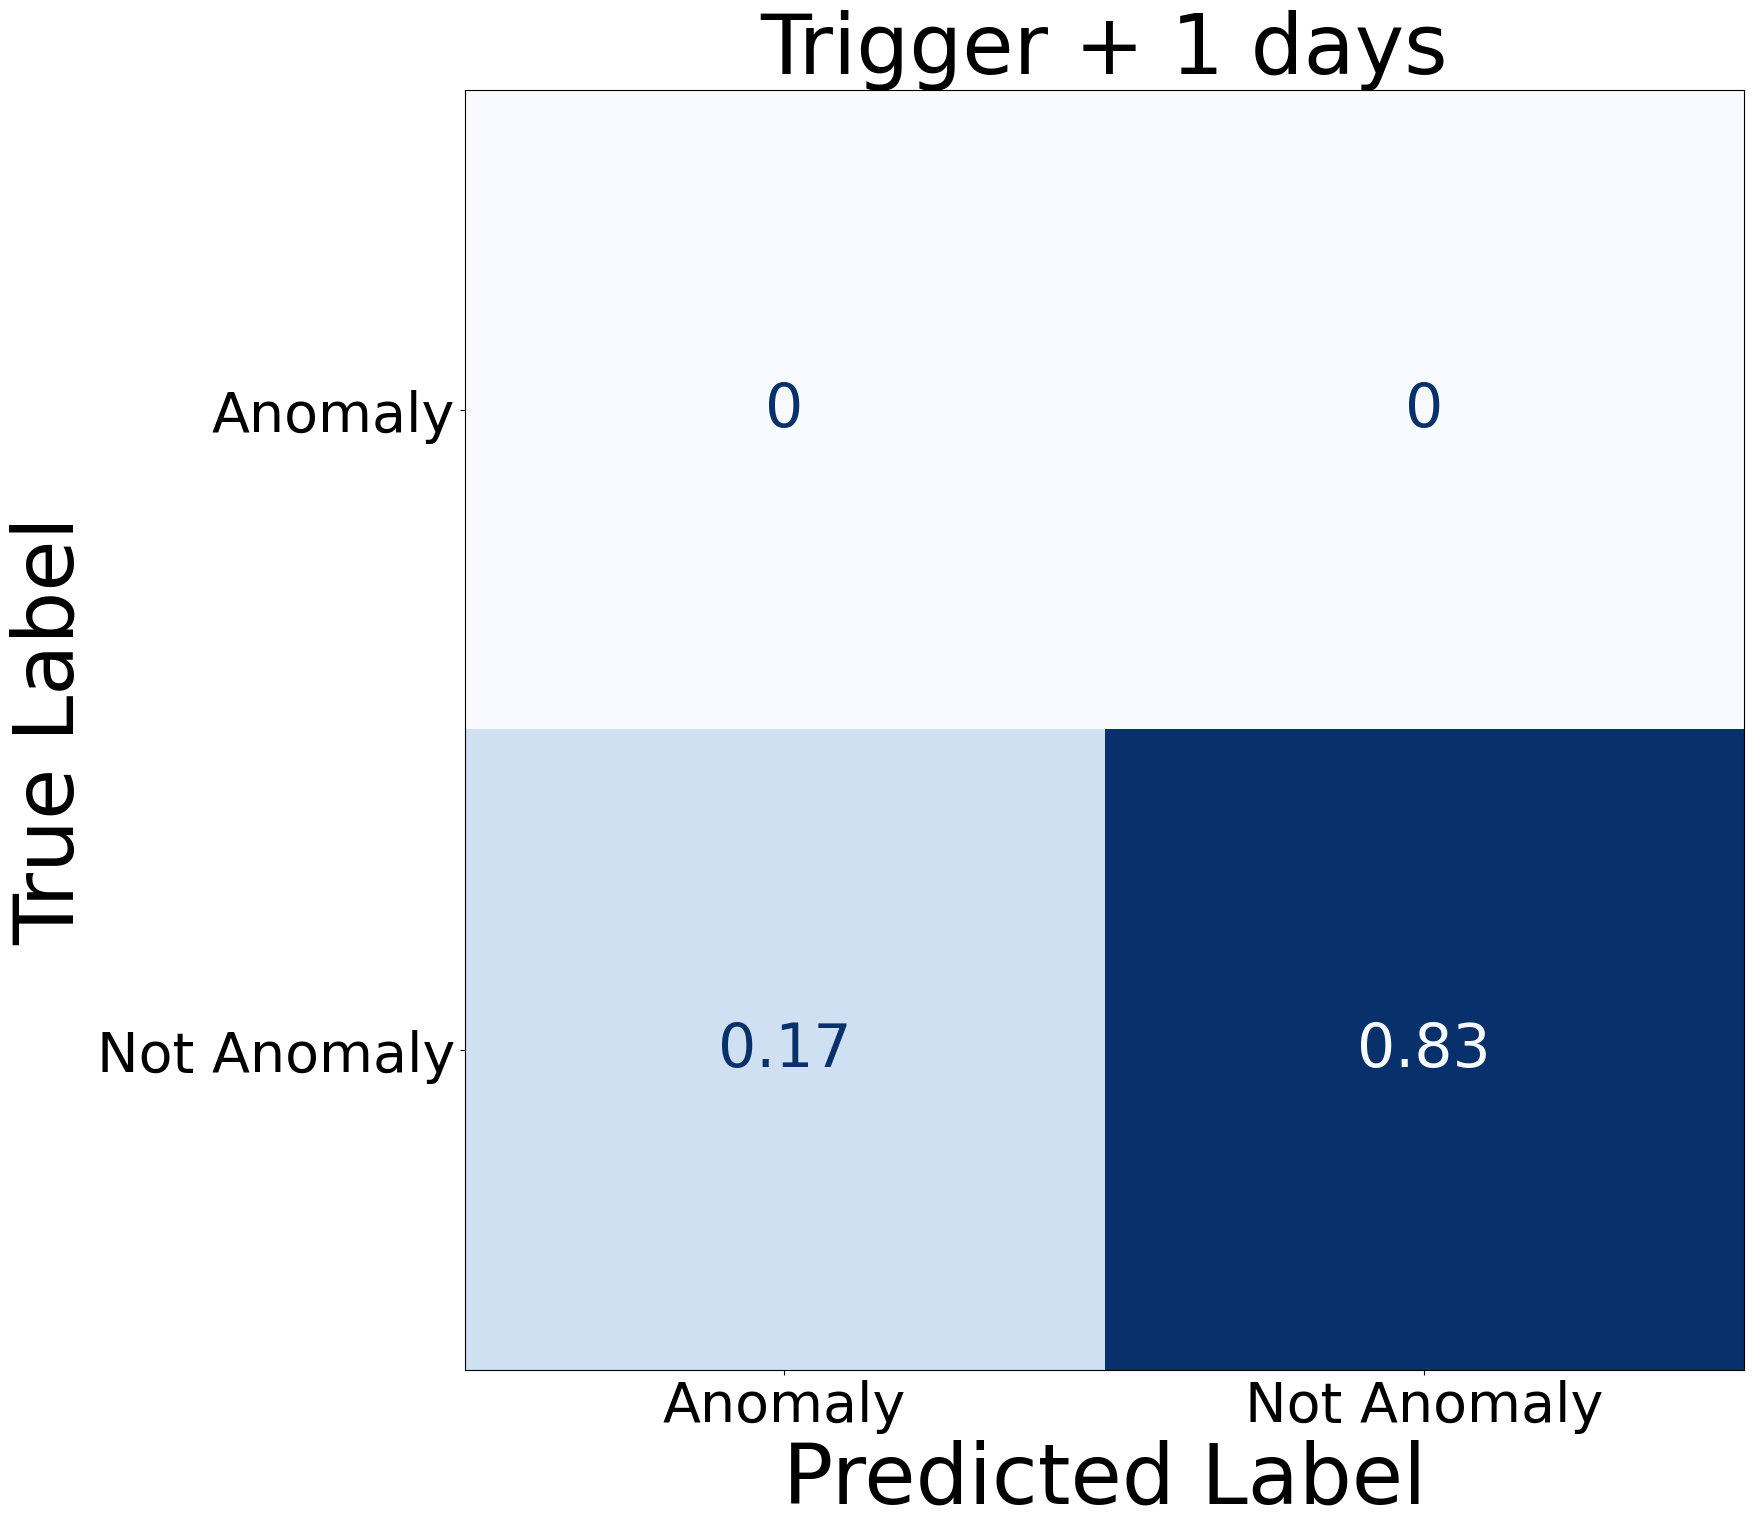

In [20]:
run_day_wise_anomaly_detection_analysis(model, tree, None, X_ts, X_static, Y, astrophysical_classes)

In [7]:
true = load(f'pickles/augmented/day2/anomalies_true.pkl')
peakmjd = load('pickles/peakmjds.pkl')
true[:3], peakmjd[:3], astrophysical_classes[:3]

([np.int64(1), np.int64(1), np.int64(1)],
 [np.float64(61176.94921875),
  np.float64(61121.9921875),
  np.float64(61162.9609375)],
 ['CART', 'CART', 'CART'])

In [11]:
list(zip(pred, true, astrophysical_classes))[:15]

NameError: name 'pred' is not defined

In [ ]:
from taxonomy import source_node_label, get_taxonomy_tree

def determine_anomalies(class_probs, tree, purity_threshold=0.7):
    # takes model output and converts to binary anomaly detection/non-detection
    level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())
    leaf_nodes = level_order_nodes[-19:]

    # indiv_probs = [class_probs[0][index] for index in range(len(class_probs))]
    indiv_probs = class_probs[0]
    class_probs_df = pd.DataFrame(indiv_probs)

    columns = level_order_nodes.copy()
    class_probs_df.columns = columns
    
    # groups nodes for anomaly detection
    anomaly_labels = class_probs_df[['KN', 'uLens', 'SLSN', 'PISN', 'TDE', 'CART', 'ILOT']]
    non_anomaly_labels = class_probs_df[['Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB', 'SNIa', 'SNIax', 'SNIb/c', 'SNI91bg', 'SNII', 'M-dwarf Flare', 'Dwarf Novae', 'AGN']]
    anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in anomaly_labels.iterrows()]
    non_anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in non_anomaly_labels.iterrows()]
    anomaly_detections = list(enumerate(zip(anomaly_preds, non_anomaly_preds)))

    # maps class labels to generate y_true for anomalies
    # labels = [class_probs[i][1] for i in range(len(class_probs))]
    labels = class_probs[1]
    anomaly_map = [
        0.0, # AGN - not anomaly
        0.0, # SNIa - not anomaly
        0.0, # SNIb/c - not anomaly
        0.0, # SNIax - not anomaly
        1.0, # SNI91bg - anomaly
        0.0, # SNII - not anomaly
        1.0, # KN - anomaly
        0.0, # Dwarf Novae - not anomaly
        1.0, # uLens - anomaly
        0.0, # M-dwarf Flare - not anomaly
        1.0, # SLSN - anomaly
        1.0, # TDE - anomaly
        1.0, # ILOT - anomaly
        1.0, # CART - anomaly
        1.0, # PISN - anomaly
        0.0, # Cepheid - not anomaly
        0.0, # RR Lyrae - not anomaly
        0.0, # Delta Scuti - not anomaly
        0.0  # EB - not anomaly
    ]
    y_true = [[anomaly_map[np.argmax(label[-19:])], 1.0 - anomaly_map[np.argmax(label[-19:])]] for label in labels]

    # reformats anomaly detections to match y_true for metric calculation
    anomaly = np.array([anomaly_detections[row][1][0] for row in range(len(anomaly_detections))])
    non_anomaly = np.array([anomaly_detections[row][1][1] for row in range(len(anomaly_detections))])
    y_pred = np.stack((anomaly, non_anomaly), axis=1)

    # converts from one hot encoding to argmax representation for sklearn.metrics functions
    true = [np.argmax(y_true[i]) for i in range(len(y_true))]
    # pred = [0 if element > purity_threshold else 1 for element in np.transpose(y_pred)[0]]
    pred = y_pred

    return true, pred

In [ ]:
from dataloader import augment_ts_length_to_days_since_trigger, get_ts_upto_days_since_trigger, get_augmented_data
from interpret_results import save_all_cf_and_rocs, save_leaf_cf_and_rocs, get_conditional_probabilites
import networkx as nx
import numpy as np
import pandas as pd
import gc

days = 2 ** np.array(range(11))
default_batch_size = 1024

def save(save_path , obj):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)

def run_day_wise_anomaly_detection_analysis(model, tree, model_dir, X_ts, X_static, Y, astrophysical_classes, purity_threshold=0.7, path="plots/daywise/"):
    
    all_predictions = []
    all_trues = []

    precision_values = []

    for d in days:

        print(f'Running inference for trigger + {d} days...')

        # if not os.path.isdir(f'pickles/augmented/day{d}'):
        #     os.makedirs(f'./pickles/augmented/day{d}')
        
        # if d == 8 or not os.path.exists(f'pickles/augmented/day{d}/x1.pkl'):
        #     x1, x2, y_true, _ = augment_ts_length_to_days_since_trigger(X_ts, X_static, Y, astrophysical_classes, d)
            
        #     save(f"pickles/augmented/day{d}/x1.pkl", x1)
        #     save(f"pickles/augmented/day{d}/x2.pkl", x2)
        #     save(f"pickles/augmented/day{d}/y.pkl", y_true)
        # else:
        #     # print(f'Loading x, y values from disk for day {d}')
        #     gc.collect()
        #     x1 = load(f"pickles/augmented/day{d}/x1.pkl")
        #     x2 = load(f"pickles/augmented/day{d}/x2.pkl")
        #     y_true = load(f"pickles/augmented/day{d}/y.pkl")
        #     # print('Loaded!')
        
        # Run inference on these
        if not os.path.exists(f'pickles/augmented/day{d}/pred.pkl'):
            y_pred = model.predict([x1, x2], batch_size=default_batch_size)
            save(f"pickles/augmented/day{d}/pred.pkl", y_pred)
            print('Saved to disk!')
        else:
            print(f'Loading y_pred values from disk for day {d}')
            y_pred = load(f'pickles/augmented/day{d}/pred.pkl')
            y_true = load(f'pickles/augmented/day{d}/y.pkl')
            print('Loaded!')

        # # Get the conditional probabilities
        _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)
        probs_with_labels = [pseudo_conditional_probabilities, y_true]

        true, pred = determine_anomalies(probs_with_labels, tree, purity_threshold=purity_threshold)
        save(f"pickles/augmented/day{d}/anomalies_true.pkl", true)
        save(f'pickles/augmented/day{d}/anomalies_pred.pkl', pred)
        
        # if not os.path.exists(f'pickles/augmented/day{d}/anomalies_true.pkl'):
        #     true, pred = determine_anomalies(probs_with_labels, tree)
        #     save(f"pickles/augmented/day{d}/anomalies_true.pkl", true)
        #     save(f'pickles/augmented/day{d}/anomalies_pred.pkl', pred)
        # else:
        #     print(f'Loading anomaly values from disk for day {d}')
        #     true = load(f'pickles/augmented/day{d}/anomalies_true.pkl')
        #     pred = load(f'pickles/augmented/day{d}/anomalies_pred.pkl')
        #     print('Loaded!')

        # print('Anomalies detected without any errors!')
        # del x1, x2, y_true, y_pred
        
        print(f'For trigger + {d} days, these are the statistics:')

        plot_title = f"Trigger + {d} days, {purity_threshold * 100}% confidence threshold"
        
        # Print all the stats and make plots...
        labels = ['Anomaly', 'Not Anomaly']
        for index, (label, prediction) in enumerate(zip(true, pred)):
            true[index] = labels[label]
            pred[index] = labels[prediction]

        current_cm = plot_confusion_matrix(true, pred, labels, title=plot_title, img_file=os.path.join(path, f'AD_{d}.png'))

        # calculates the precision at the specific day and adds to data set
        precision_values.append(current_cm[0][0] / (current_cm[0][0] + current_cm[1][0]))
        
    return precision_values

def make_gif(files, gif_file=None):

    # Load the images
    images = []
    for filename in files:
        images.append(imageio.imread(filename))

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(18, 18))

    # Create the animation
    def animate(i):
        ax.clear()
        ax.axis('off')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(images[i])

    fig.tight_layout()
        
    anim = animation.FuncAnimation(fig, animate, frames=len(images), interval=500)

    if gif_file:
        # Save the animation as a GIF
        anim.save(gif_file)

In [8]:
train = LSSTSourceDataSet("./../../train_parquet-001.parquet")

Loading parquet dataset: ./../../train_parquet-001.parquet
Number of sources: 1081614


In [26]:
from taxonomy import source_node_label, get_taxonomy_tree
import networkx as nx
from tensorflow.keras.utils import pad_sequences

tree = get_taxonomy_tree()
level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())
leaf_nodes = level_order_nodes[-19:]

anomaly_percentages = []
# train = LSSTSourceDataSet("../../train_parquet-001.parquet")

def augment_ts_length_to_days_since_trigger(X_ts, X_static, Y, a_classes, days):

    # Augment the length of the ts data
    X_ts, get_ts_upto_days_since_trigger(X_ts, days=days)

    # Squeeze data into homogeneously shaped numpy arrays
    X_ts = np.squeeze(X_ts)
    X_static = np.squeeze(X_static)
    Y = np.squeeze(Y).astype(np.float32)
    astrophysical_classes = np.squeeze(a_classes)

    return X_ts, X_static, Y, astrophysical_classes

#     r_band = np.array(X_ts['scaled_FLUXCAL'][np.where(X_ts['band_label'] == LSST_Source.pb_wavelengths['r'])] * LSST_Source.flux_scaling_const)

def get_ts_upto_days_since_trigger(X_ts, days, add_padding=True):

    augmented_list = []

    # Loop through all the data
    for ind in tqdm(range(len(X_ts)), desc ="TS Augmentation: ", disable=False):

        times = X_ts[ind]['scaled_time_since_first_obs'].to_numpy()

        # Get the idx of the first detection
        first_detection_idx = np.where(X_ts[ind]['detection_flag'].to_numpy() == 1)[0][0]
        first_detection_t = times[first_detection_idx]

        if len(np.where((times - first_detection_t) * 100 <= days)[0]) == 0:
            augmented_list.append(np.zeros_like(X_ts[ind].to_numpy()))
        else:
            # Get the index of the the last observation between the mjd(first detection) and  mjd(first detection)
            last_observation_idx = np.where((times - first_detection_t) * 100 <= days)[0][-1]
            
            # Slice the data appropriately, Keep the first new_length number of observations and all columns
            augmented_list.append(X_ts[ind].to_numpy()[:(last_observation_idx + 1), :])

    # Optionally - Pad for TF masking layer
    if add_padding:
        augmented_list = pad_sequences(augmented_list, maxlen=ts_length,  dtype='float32', padding='post', value=ts_flag_value)

    return augmented_list

def get_ts_upto_days_since_trigger_with_peakmjd(X_ts, unscaled_X_ts, peakmjds, days, astrophysical_classes, add_padding=True):

    augmented_list = []
    days_since_peak = []

    # Loop through all the data
    for ind in tqdm(range(len(X_ts)), desc ="TS Augmentation: ", disable=False):

        times = X_ts[ind]['scaled_time_since_first_obs'].to_numpy()

        # Get the idx of the first detection
        first_detection_idx = np.where(X_ts[ind]['detection_flag'].to_numpy() == 1)[0][0]
        first_detection_t = times[first_detection_idx]

        if len(np.where((times - first_detection_t) * 100 <= days)[0]) == 0:
            augmented_list.append(np.zeros_like(X_ts[ind].to_numpy()))
        else:
            # Get the index of the the last observation between the mjd(first detection) and  mjd(first detection)
            last_observation_idx = np.where((times - first_detection_t) * 100 <= days)[0][-1]

            # source, class_labels, snid = train.get_item(ind)
            # table2, peakmjd = source.get_custom_table()
            
            # print(f'Iter: {ind}')
            # print(X_ts[ind].to_numpy()[last_observation_idx])
            # print(table2.as_array()[last_observation_idx])
            # print(f'PEAKMJD: {peakmjds[ind]}')

            # if astrophysical_classes[ind] == 'SNII':
            #     print(unscaled_X_ts[ind][last_observation_idx])
            #     print(peakmjds[ind])
            
            days_since_peak.append((unscaled_X_ts[ind][last_observation_idx][0] - peakmjds[ind], astrophysical_classes[ind]))
            # print(days_since_peak)
            
            # Slice the data appropriately, Keep the first new_length number of observations and all columns
            augmented_list.append(X_ts[ind].to_numpy()[:(last_observation_idx + 1), :])

    # Optionally - Pad for TF masking layer
    if add_padding:
        augmented_list = pad_sequences(augmented_list, maxlen=ts_length,  dtype='float32', padding='post', value=ts_flag_value)

    return augmented_list, days_since_peak
    
def predict_partial_lc(model, tree, model_dir, X_ts, X_static, Y, astrophysical_classes, dataset, purity_threshold=0.7, path="plots/daywise/"):    
    all_predictions = []
    all_trues = []
    predicted_class = []

    precision_values = []

    # days = [num for num in range(2, 61, 2)]
    n = 7
    days = np.squeeze(np.multiply([table['scaled_time_since_first_obs'][np.where(table['band_label'] == LSST_Source.pb_wavelengths['r'])]], 100))[:n]
    r_bands = np.squeeze(np.array([table['scaled_FLUXCAL'][np.where(table['band_label'] == LSST_Source.pb_wavelengths['r'])]]))[:n]
    
    for d in days:

        print(f'Running inference for trigger + {d} days...')
        x1, x2, y_true, _ = augment_ts_length_to_days_since_trigger(X_ts, X_static, Y, astrophysical_classes, d)
        # print(r_band)
        y_pred = model.predict([x1, x2], batch_size=1)

        # Get the conditional probabilities
        _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)
        probs_with_labels = [pseudo_conditional_probabilities, y_true]

        true, pred = determine_anomalies(probs_with_labels, tree, purity_threshold=0.5)

        predicted_class.append([leaf_nodes[class_name] for class_name in [np.argmax(probs[-19:]) for probs in pseudo_conditional_probabilities]])
        print([leaf_nodes[class_name] for class_name in [np.argmax(probs[-19:]) for probs in pseudo_conditional_probabilities]])
        # print(astrophysical_classes)
        print(pred.T[0])
        anomaly_percentages.append(pred.T[0])
        all_r_bands.append(r_bands)

    return predicted_class, anomaly_percentages, all_r_bands

In [23]:
unscaled_X_ts = unscaled_X_ts1 + unscaled_X_ts2

In [24]:
len(unscaled_X_ts)

1081614

In [27]:
days = 1
augmented, days_since_peak = get_ts_upto_days_since_trigger_with_peakmjd(X_ts, unscaled_X_ts, peakmjds, days, astrophysical_classes)
# times = X_ts[0]['scaled_time_since_first_obs'].to_numpy()
# times * 100

TS Augmentation: 100%|██████████| 1081614/1081614 [11:27<00:00, 1572.31it/s]


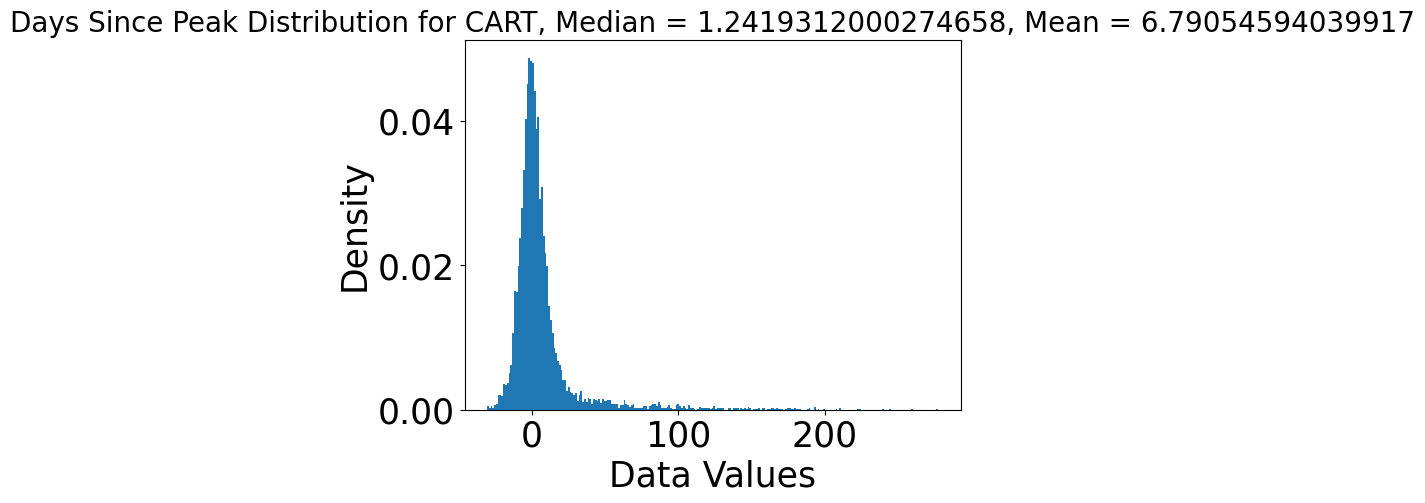

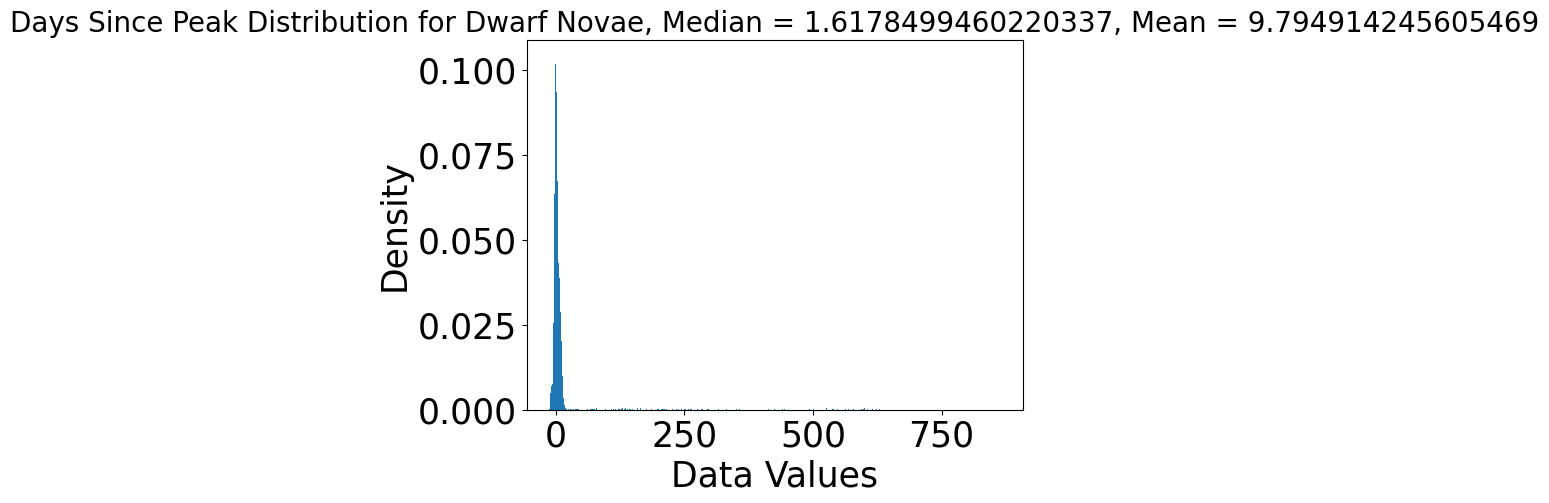

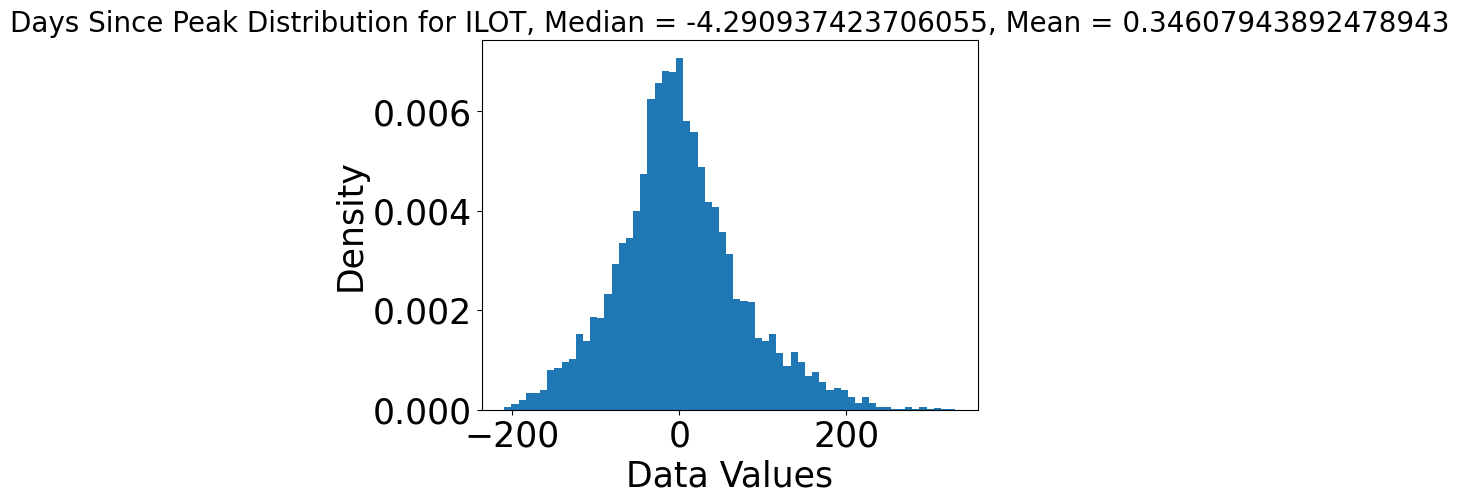

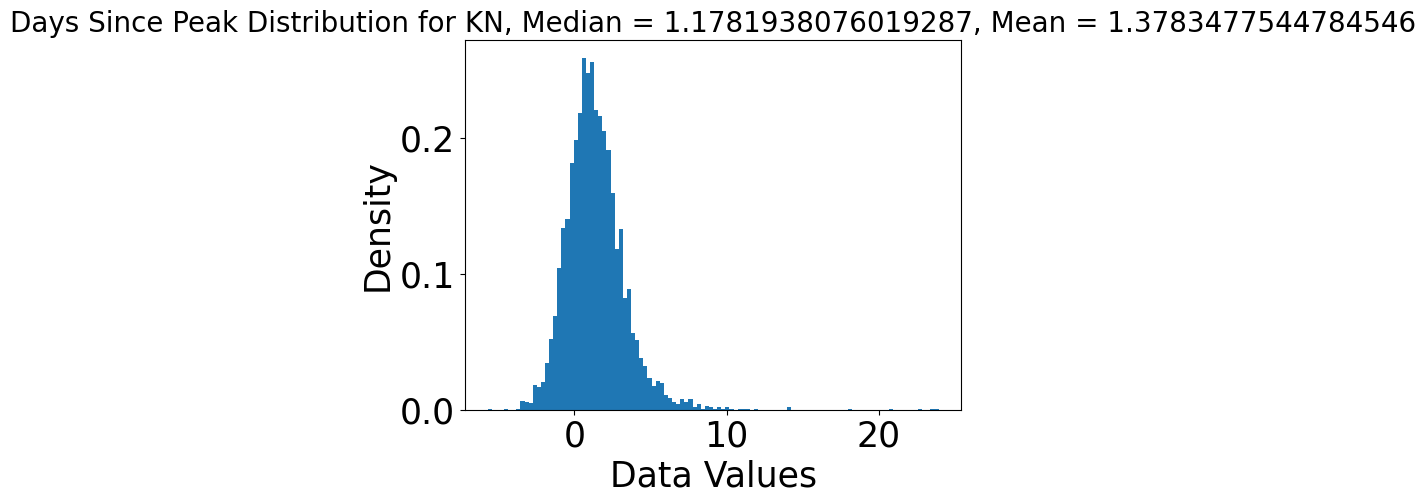

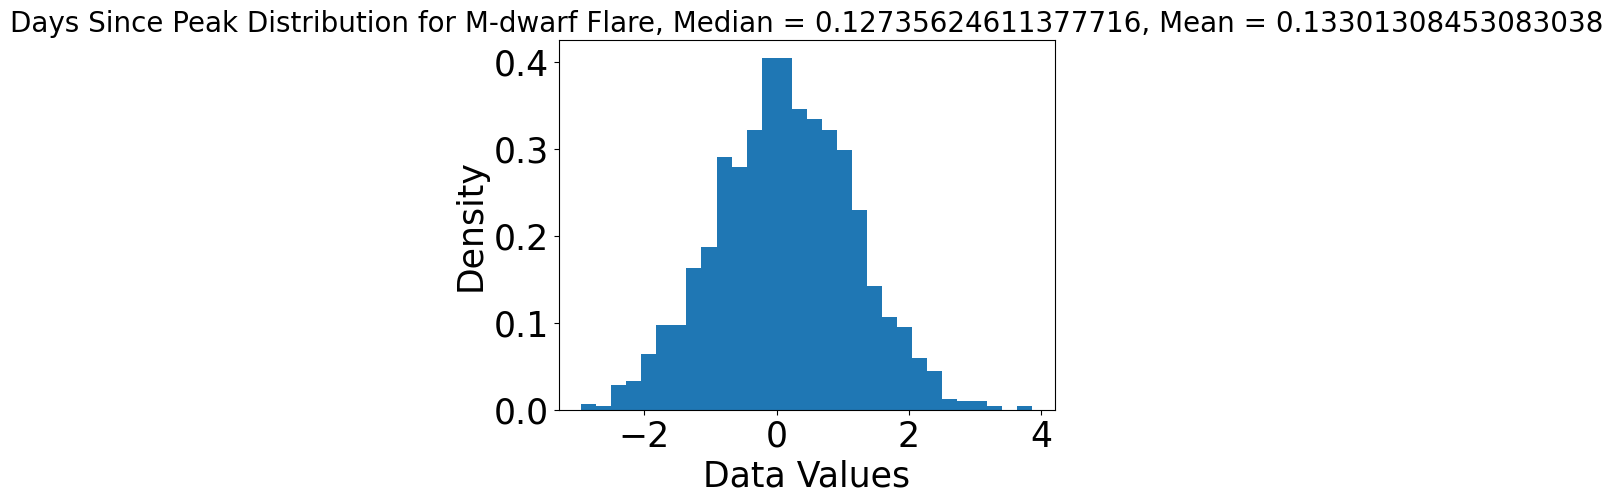

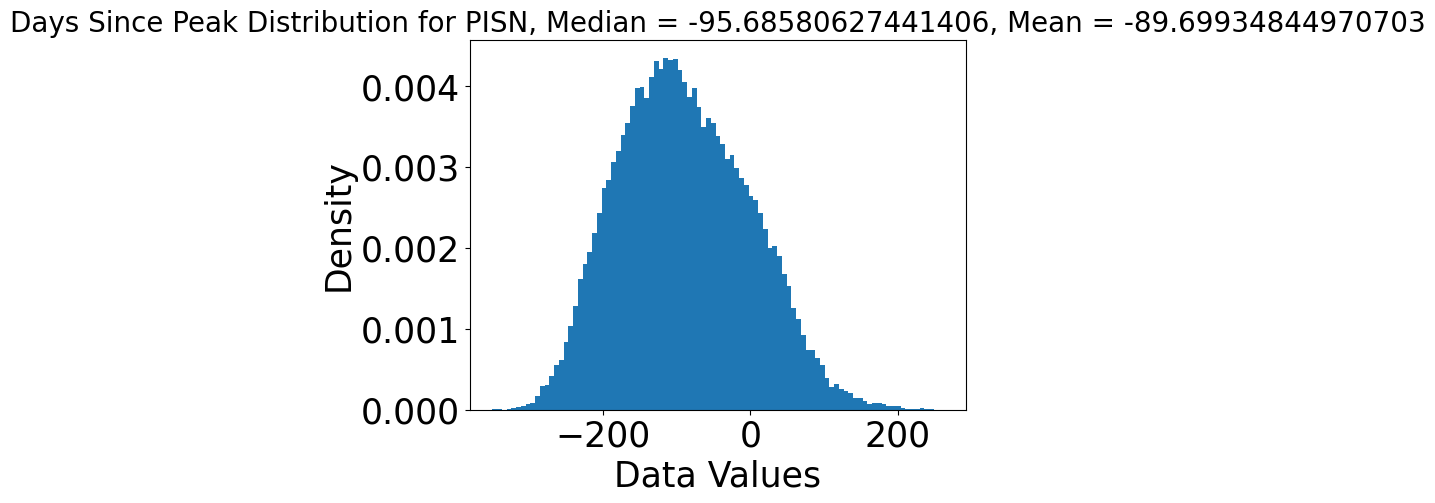

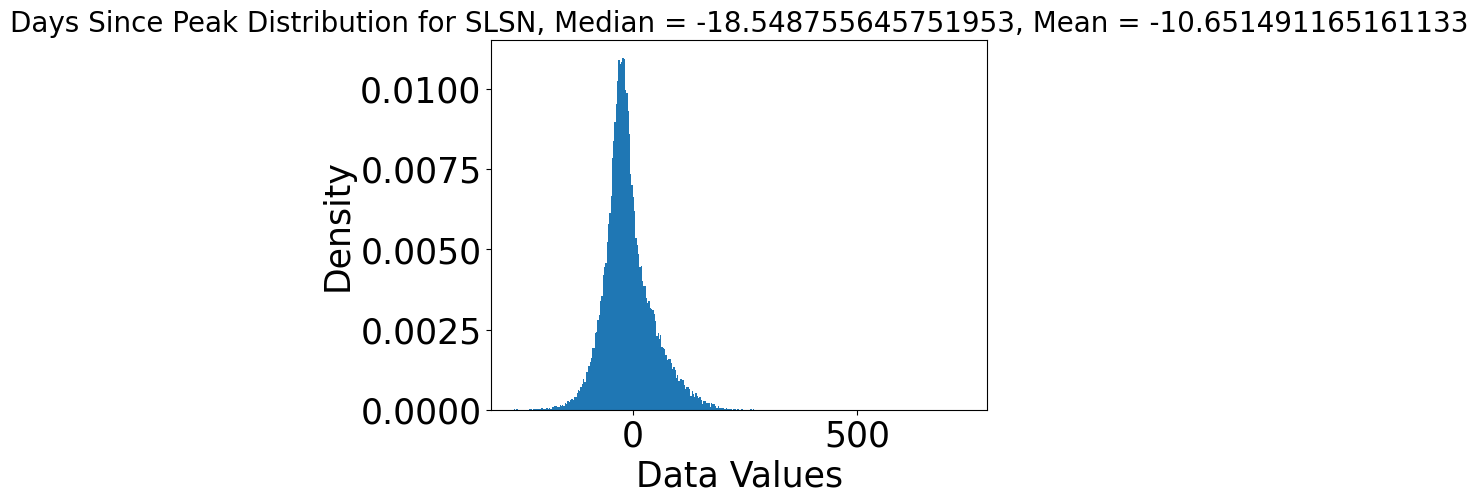

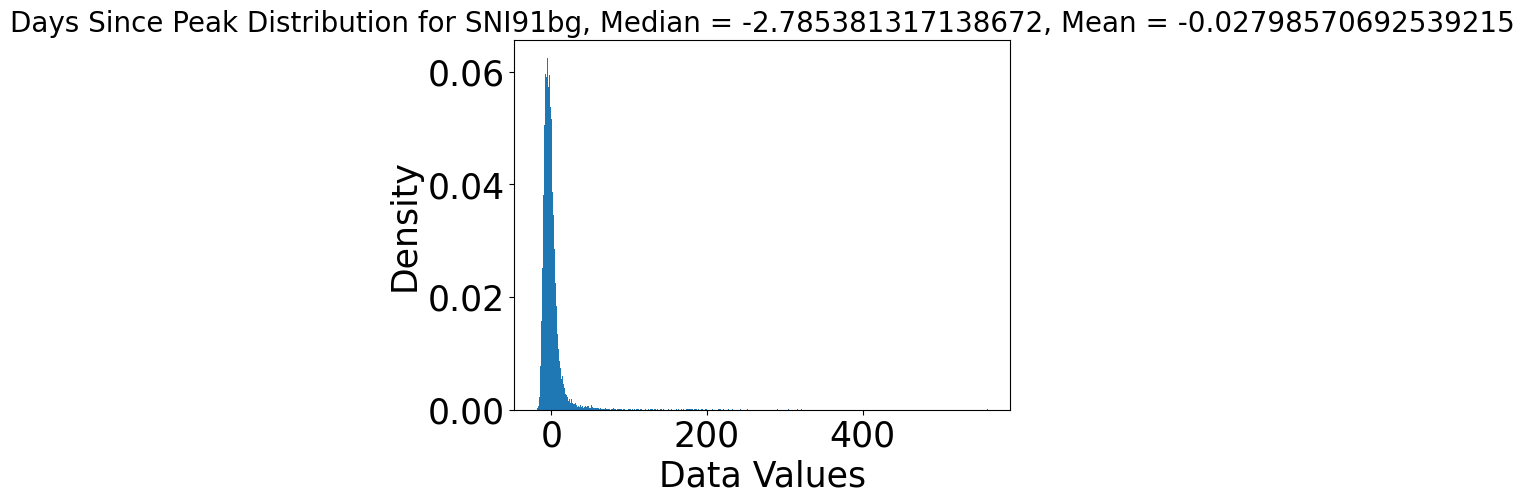

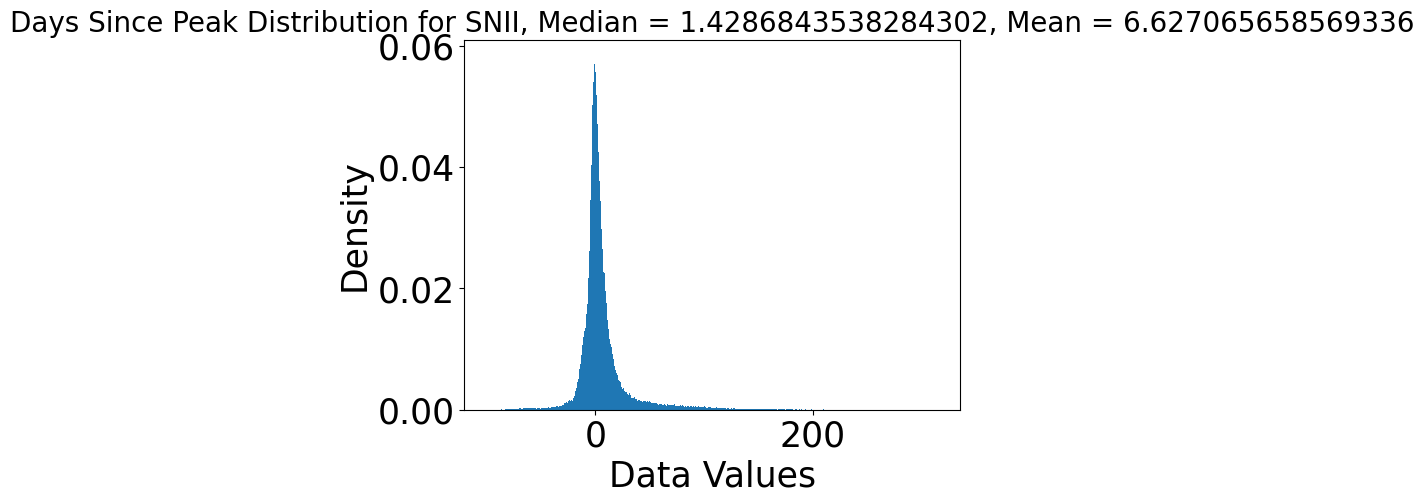

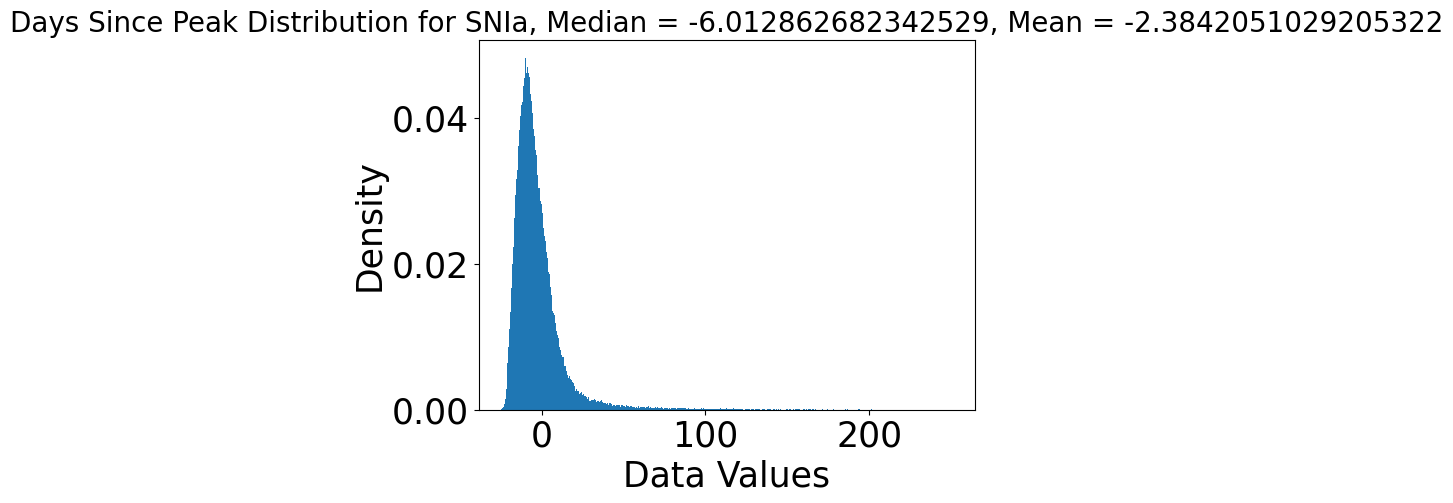

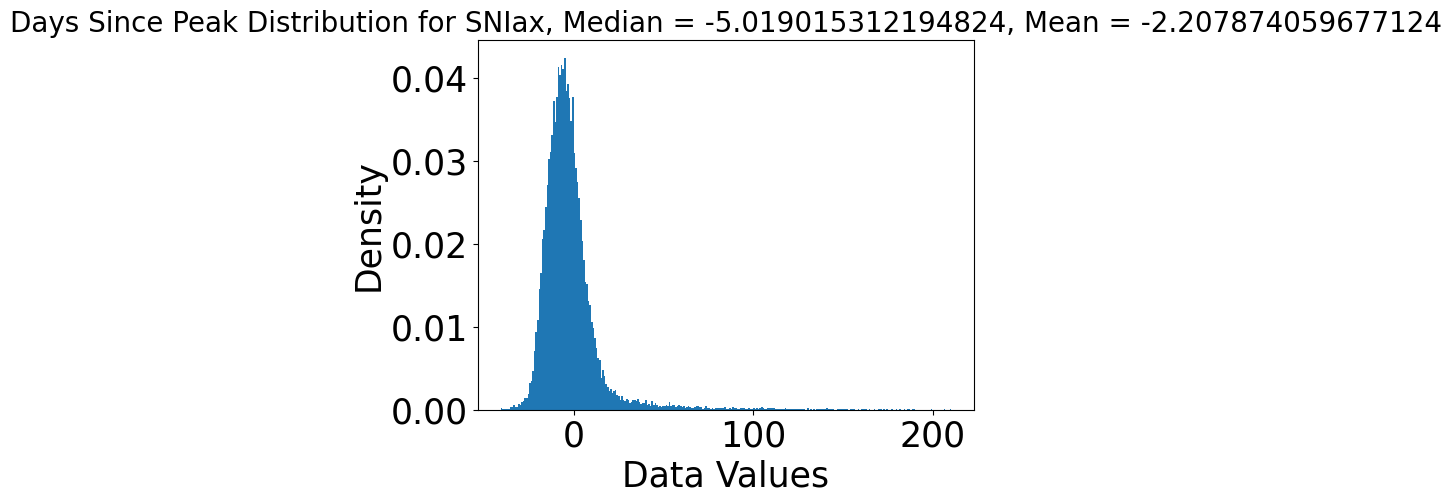

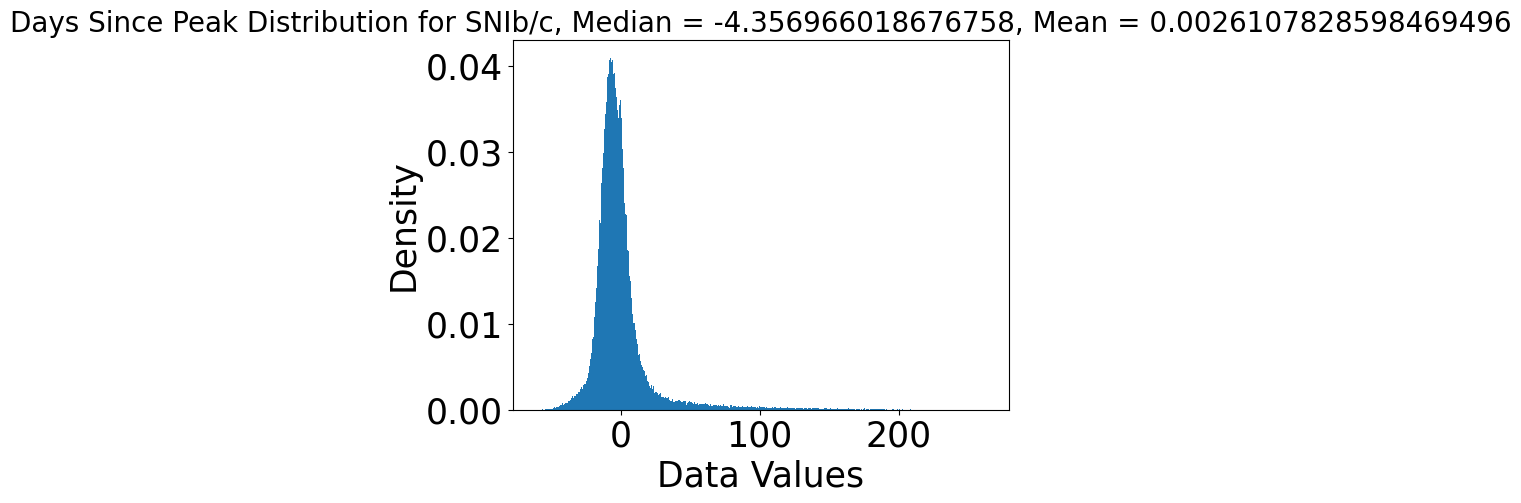

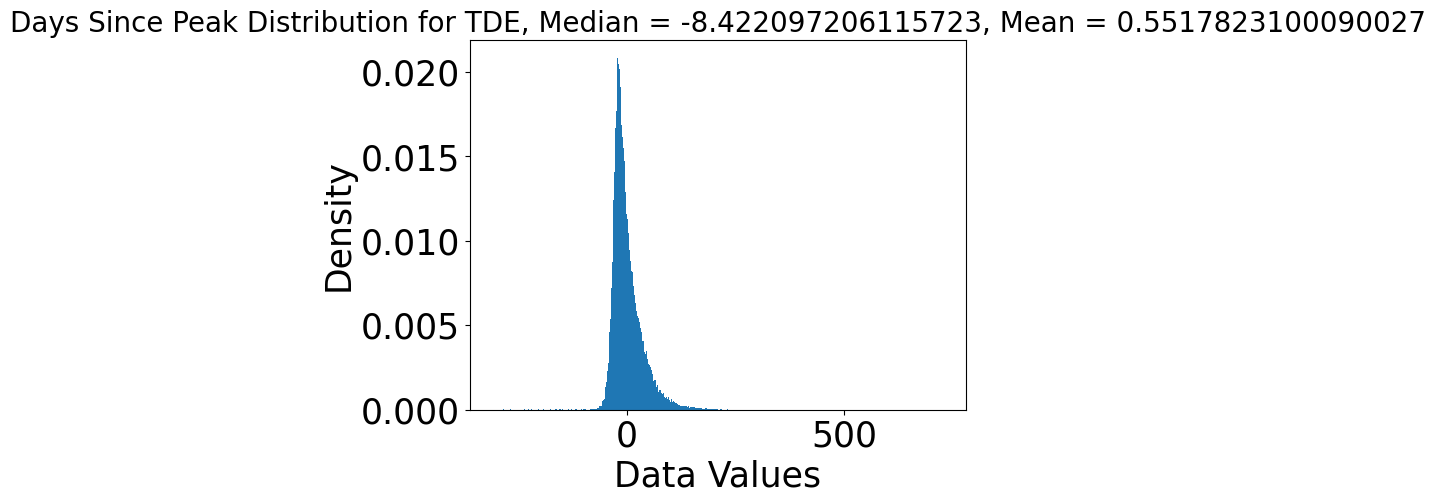

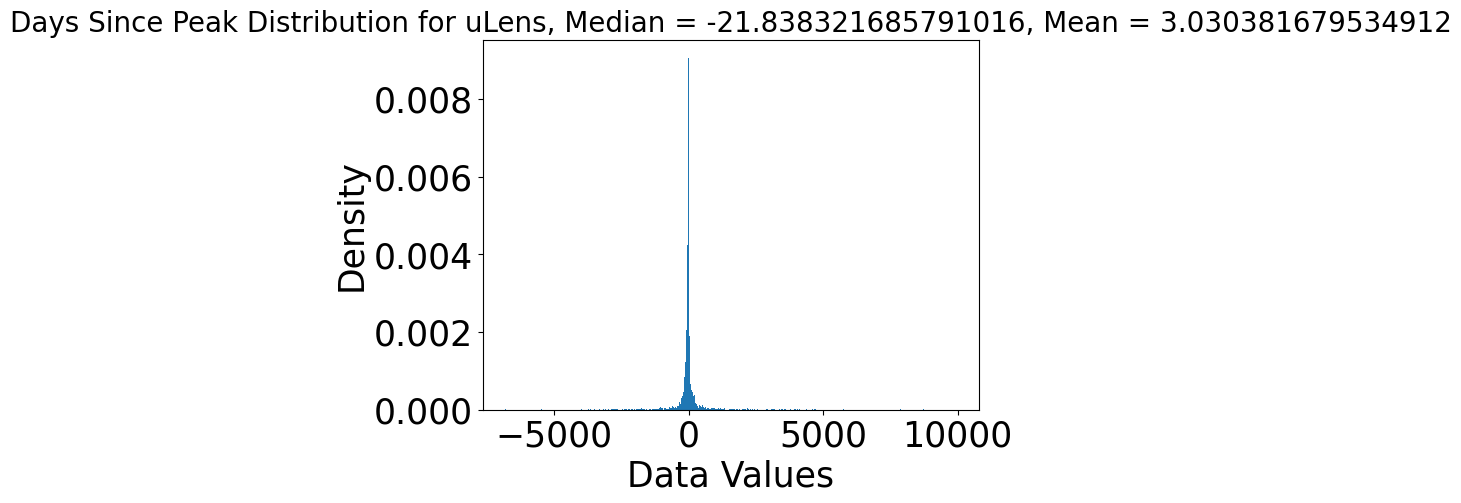

array(['CART', '6.790546', 'Dwarf Novae', '9.794914', 'ILOT',
       '0.34607944', 'KN', '1.3783478', 'M-dwarf Flare', '0.13301308',
       'PISN', '-89.69935', 'SLSN', '-10.651491', 'SNI91bg',
       '-0.027985707', 'SNII', '6.6270657', 'SNIa', '-2.384205', 'SNIax',
       '-2.207874', 'SNIb/c', '0.0026107829', 'TDE', '0.5517823', 'uLens',
       '3.0303817'], dtype='<U32')

In [35]:
def calc_average_days_since_peak(days_since_peak, astrophysical_classes, info=False):
    days_since_peak = np.array(days_since_peak)
    averages = np.array([])

    for class_name in np.unique(astrophysical_classes):
        if class_name != 'AGN' and class_name != 'Cepheid' and class_name != 'EB' and class_name != 'RR Lyrae' and class_name != 'Delta Scuti':
            idxs = np.where(days_since_peak[:, 1] == class_name)
            days = np.squeeze(days_since_peak[idxs, 0].astype(np.float32))
            average = np.sum(days) / days.shape[0]
    
            if info:
                plt.hist(days, bins='auto', density=True)
                plt.xlabel("Data Values")
                plt.ylabel("Density")
                plt.title(f"Days Since Peak Distribution for {class_name}, Median = {np.median(days)}, Mean = {np.mean(days)}", fontsize=20)
                plt.show()
            
            # print(average)
            averages = np.append(averages, (class_name, average))

    return averages

calc_average_days_since_peak(days_since_peak, astrophysical_classes, info=True)

In [110]:
phase = np.array([])
days = 2 ** np.array(range(11))

for day in days:
    print(f'Day {day}')
    augmented, days_since_peak = get_ts_upto_days_since_trigger_with_peakmjd(X_ts, unscaled_X_ts, peakmjds, day, astrophysical_classes)
    daily_averages = calc_average_days_since_peak(days_since_peak, astrophysical_classes)
    phase = np.append(phase, daily_averages)

phase.shape

Day 1


TS Augmentation: 100%|██████████| 1081614/1081614 [11:54<00:00, 1514.86it/s]


169.98456
6.790546
111.150444
70.46019
9.794914
170.2154
0.34607944
1.3783478
0.13301308
-89.69935
70.25817
-10.651491
-0.027985707
6.6270657
-2.384205
-2.207874
0.0026107829
0.5517823
3.0303817
Day 2


TS Augmentation: 100%|██████████| 1081614/1081614 [08:28<00:00, 2126.95it/s]


170.25604
7.076266
111.27912
70.62847
10.0744
170.50307
0.6217027
1.7350718
0.47022492
-89.441826
70.425804
-10.3954525
0.27356762
6.918886
-2.0992947
-1.9211783
0.28941703
0.8288501
3.2711577
Day 4


TS Augmentation: 100%|██████████| 1081614/1081614 [08:39<00:00, 2082.62it/s]


171.28383
8.054823
111.927666
71.44384
10.950086
171.5413
1.613224
2.7514346
1.5067238
-88.56219
71.208145
-9.528428
1.2231842
7.9117866
-1.1358677
-0.9289639
1.243174
1.8018705
4.078893
Day 8


TS Augmentation: 100%|██████████| 1081614/1081614 [08:28<00:00, 2128.56it/s]


174.1135
10.652752
114.077354
74.12175
13.387414
174.4856
4.1826944
5.5157785
4.2979436
-86.15809
73.78223
-7.147226
3.7709098
10.519745
1.4177221
1.6678138
3.791343
4.3719697
6.371511
Day 16


TS Augmentation: 100%|██████████| 1081614/1081614 [08:36<00:00, 2092.47it/s]


181.28644
17.265373
122.93201
82.2225
19.680603
181.92114
10.984606
12.323503
10.944999
-79.191635
81.734985
-0.63330275
10.428425
17.117393
8.016925
8.271886
10.407319
10.873719
13.042762
Day 32


TS Augmentation: 100%|██████████| 1081614/1081614 [09:09<00:00, 1967.54it/s]


196.0906
31.134302
139.5615
98.5069
33.40602
197.16595
25.694798
26.26424
25.24696
-64.46173
97.52686
13.37443
24.123598
31.035044
21.775276
22.05695
24.191462
24.996506
27.424442
Day 64


TS Augmentation: 100%|██████████| 1081614/1081614 [10:47<00:00, 1669.24it/s]


224.30856
55.082073
169.60553
129.77711
56.916553
226.25623
52.31555
49.861813
49.870316
-36.136112
128.1766
39.28269
47.594486
55.17773
45.658245
45.909492
48.27861
49.87809
53.70432
Day 128


TS Augmentation: 100%|██████████| 1081614/1081614 [11:26<00:00, 1576.33it/s]


267.51508
87.59442
234.03297
192.13724
87.73277
273.98193
91.92567
78.99938
78.7703
9.632051
187.08458
79.37225
79.05408
87.39877
78.03076
77.946175
81.26766
85.01508
96.50505
Day 256


TS Augmentation: 100%|██████████| 1081614/1081614 [11:47<00:00, 1528.41it/s]


319.57248
149.39824
281.95248
235.27559
155.36913
317.67905
143.11084
142.10161
132.5571
62.357872
236.37466
136.85866
146.75357
148.25601
144.04626
142.1883
145.92596
140.91469
154.39621
Day 512


TS Augmentation: 100%|██████████| 1081614/1081614 [11:47<00:00, 1529.39it/s]


622.2789
353.70932
613.5123
569.04114
353.67148
630.5591
358.00638
338.5087
335.9012
295.30408
564.1757
345.93338
346.22394
337.44315
339.5116
344.24667
332.52365
348.19962
380.5739
Day 1024


TS Augmentation: 100%|██████████| 1081614/1081614 [08:15<00:00, 2183.69it/s]


992.0533
418.90955
1007.0328
959.63525
506.70306
983.0296
515.3963
340.18958
489.1418
433.8728
968.45325
500.57718
358.54004
357.89862
345.8036
373.535
338.11472
459.35742
575.89087


(209,)

In [11]:
phase = load('pickles/phase.pkl')
phase

array([ 169.98455811,    6.79054594,  111.15044403,   70.46018982,
          9.79491425,  170.21539307,    0.34607944,    1.37834775,
          0.13301308,  -89.69934845,   70.25817108,  -10.65149117,
         -0.02798571,    6.62706566,   -2.3842051 ,   -2.20787406,
          0.00261078,    0.55178231,    3.03038168,  170.25604248,
          7.07626581,  111.2791214 ,   70.62847137,   10.07439995,
        170.50306702,    0.62170267,    1.73507178,    0.47022492,
        -89.44182587,   70.42580414,  -10.3954525 ,    0.27356762,
          6.91888618,   -2.09929466,   -1.92117834,    0.28941703,
          0.82885009,    3.27115774,  171.28382874,    8.05482292,
        111.92766571,   71.44384003,   10.95008564,  171.54130554,
          1.61322403,    2.75143456,    1.50672376,  -88.56218719,
         71.20814514,   -9.52842808,    1.22318423,    7.91178656,
         -1.13586771,   -0.9289639 ,    1.24317396,    1.80187047,
          4.07889318,  174.11349487,   10.65275192,  114.07735

In [12]:
phase = phase.reshape((11, 19))
np.set_printoptions(suppress=True)
phase[]

array([[ 169.98455811,    6.79054594,  111.15044403,   70.46018982,
           9.79491425,  170.21539307,    0.34607944,    1.37834775,
           0.13301308,  -89.69934845,   70.25817108,  -10.65149117,
          -0.02798571,    6.62706566,   -2.3842051 ,   -2.20787406,
           0.00261078,    0.55178231,    3.03038168],
       [ 170.25604248,    7.07626581,  111.2791214 ,   70.62847137,
          10.07439995,  170.50306702,    0.62170267,    1.73507178,
           0.47022492,  -89.44182587,   70.42580414,  -10.3954525 ,
           0.27356762,    6.91888618,   -2.09929466,   -1.92117834,
           0.28941703,    0.82885009,    3.27115774],
       [ 171.28382874,    8.05482292,  111.92766571,   71.44384003,
          10.95008564,  171.54130554,    1.61322403,    2.75143456,
           1.50672376,  -88.56218719,   71.20814514,   -9.52842808,
           1.22318423,    7.91178656,   -1.13586771,   -0.9289639 ,
           1.24317396,    1.80187047,    4.07889318],
       [ 174.11349487,

In [ ]:
from tensorflow.keras.utils import pad_sequences
anomalous_classes = ['KN', 'uLens', 'SLSN', 'PISN', 'TDE', 'CART', 'ILOT']
class_count = 1

X_ts_class = []
X_static_class = []
Y_class = []
snids = [58373175, 41513701, 68855884, 38352249, 54732684, 73817174, 57303432]

train = LSSTSourceDataSet("./../../train_parquet-001.parquet")

source, labels, snid, class_label = train.get_item_from_snid(58373175)
table = source.get_event_table()

for j, c in enumerate(anomalous_classes): # iterates over each leaf node class

    # gets the correct set of time series and static features from every lightcurve for that specific class by matching them up using the correct index
    idx = list(np.where(np.array(astrophysical_classes) == c)[0])[:class_count]
    X_ts_class.append(X_ts[idx[0]])
    X_static_class.append(X_static[idx[0]])
    Y_class.append(Y[idx[0]])

x = (X_ts_class, X_static_class, Y_class, astrophysical_classes)
predicted_class, anomaly_percentages, r_bands = predict_partial_lc(model, tree, None, x[0], x[1], x[2], x[3])

In [ ]:
predicted_class = np.array(predicted_class)
anomaly_percentages = np.array(anomaly_percentages)

snids = [58373175, 41513701, 68855884, 38352249, 54732684, 73817174, 57303432]
snids = snids * 2
days = [num for num in range(2, 61, 2)]
columns = days.copy()
columns.insert(0, 'SNID')

mjd = 2 ** np.array((range(11)))
data = np.concatenate((predicted_class, anomaly_percentages), axis=1)
df = pd.DataFrame(data=data).T
ids = pd.DataFrame(snids)
df = pd.concat([ids, df], axis=1)
df = pd.concat([pd.DataFrame(r_bands), df], axis=0)
df.columns = columns
df

In [ ]:
print(len(r_bands[4]))

In [ ]:
# histogram for falsely predicted class
false_anomalies = []
false_non_anomalies = []

for i in range(len(true)):
    if true[i] == 1 and pred[i] == 0:
        false_anomalies.append(pred_labels[i])
    elif true[i] == 0 and pred[i] == 1:
        false_non_anomalies.append(pred_labels[i])

plot_titles = ['False Anomalies', 'False Non-Anomalies']
x_axes = ['True Class'] * 2
y_axes = ['Count'] * 2
data = [false_anomalies, false_non_anomalies]

from collections import Counter
# print(false_non_anomalies)
# print(len(false_non_anomalies))
print(Counter(false_anomalies))

plt.rc('axes', titlesize=30)

f, a = plt.subplots(2, 1, figsize=(35,25))
a = a.ravel()
for idx,ax in enumerate(a):
    label_names = []
    x_positions = []
    
    values, bins, bars = ax.hist(data[idx], rwidth=1, bins=(4 if idx == 0 else 15))
    ax.set_title(plot_titles[idx])
    ax.set_xlabel(x_axes[idx], fontsize=20.0)
    ax.set_ylabel(y_axes[idx], fontsize=20.0)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.bar_label(bars, fontsize=20, color='r')
    ax.margins(x=0)

    if idx == 0:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        print(labels)
        label_names = ['SNI91bg', 'CART', 'SNIb/c', 'TDE']
        label_names.append(' ')
        x_positions = np.linspace(0.5, 3.5, len(label_names))
        print(label_names)
        plt.xticks(ticks=x_positions, labels=label_names, rotation=90, ha='center')

    if idx == 1:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        label_names = [np.array(labels)[i]._text for i in range(len(labels))]
        label_names.append(' ')
        x_positions = np.linspace(0.5, 14.5, len(label_names))
        plt.xticks(ticks=x_positions, labels=label_names, rotation=0, ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# histogram for falsely predicted class
false_anomalies = []
false_non_anomalies = []

for i in range(len(true)):
    if true[i] == 1 and pred[i] == 0:
        false_anomalies.append(pred_labels[i])
    elif true[i] == 0 and pred[i] == 1:
        false_non_anomalies.append(pred_labels[i])

plot_titles = ['False Anomalies', 'False Non-Anomalies']
x_axes = ['True Class'] * 2
y_axes = ['Count'] * 2
data = [false_anomalies, false_non_anomalies]

from collections import Counter
# print(false_non_anomalies)
# print(len(false_non_anomalies))
print(Counter(false_anomalies))

plt.rc('axes', titlesize=30)

f, a = plt.subplots(2, 1, figsize=(35,25))
a = a.ravel()
for idx,ax in enumerate(a):
    label_names = []
    x_positions = []
    
    values, bins, bars = ax.hist(data[idx], rwidth=1, bins=(4 if idx == 0 else 15))
    ax.set_title(plot_titles[idx])
    ax.set_xlabel(x_axes[idx], fontsize=20.0)
    ax.set_ylabel(y_axes[idx], fontsize=20.0)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.bar_label(bars, fontsize=20, color='r')
    ax.margins(x=0)

    if idx == 0:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        print(labels)
        label_names = ['SNI91bg', 'CART', 'SNIb/c', 'TDE']
        label_names.append(' ')
        x_positions = np.linspace(0.5, 3.5, len(label_names))
        print(label_names)
        plt.xticks(ticks=x_positions, labels=label_names, rotation=90, ha='center')

    if idx == 1:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        label_names = [np.array(labels)[i]._text for i in range(len(labels))]
        label_names.append(' ')
        x_positions = np.linspace(0.5, 14.5, len(label_names))
        plt.xticks(ticks=x_positions, labels=label_names, rotation=0, ha='center')

plt.tight_layout()
plt.show()

In [ ]:
data = [false_anomalies]

x_axes = ['True Class']
y_axes = ['Count']


values, bins, bars = plt.hist(data, rwidth=1, bins=4)
ax.set_title(plot_titles)
ax.set_xlabel(x_axes, fontsize=20.0)
ax.set_ylabel(y_axes, fontsize=20.0)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.bar_label(bars, fontsize=20, color='r')
ax.margins(x=0)

plt.gcf().subplots_adjust(bottom=0.25)
locs, labels = plt.xticks()
print(labels)
label_names = [np.array(labels)[i]._text for i in range(len(labels))]
label_names.append(' ')
x_positions = np.linspace(0.5, 3.5, len(label_names))
print(label_names)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics

true = [np.argmax(y_true[i]) for i in range(len(y_true))]
pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

cm = metrics.confusion_matrix(true, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
from pandas.plotting import table

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

report = metrics.classification_report(true, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.index = ['Anomaly', 'Non-Anomaly'] + df.index[2:].tolist()

# table(ax, df)
# plt.savefig('classification_report.png')

dfi.export(df, 'classification_report.png', fontsize=3.8, dpi=800,  table_conversion='celenium', chrome_path=None)

In [ ]:
# checking which lightcurves are classified incorrectly
list(enumerate([true[i] == pred[i] for i in range(len(true))]))

In [ ]:
# saving model outputs so that they can be used again without having to re-run the model every time
!touch logits.npy

def save_logits():
    with open('logits.npy', 'wb') as f:
        np.save(f, logits)

def load_logits():
    logits = np.load('logits.npy')

# The function calls can be uncommented as needed and then the cell can be run to either save the current predictions or load the previous ones
# save_logits()
# load_logits()

**Visualizing model output**

In [ ]:
import networkx as nx
from taxonomy import source_node_label

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())
# print(class_probs[0][0].shape)

class_info = pd.DataFrame()

for index in range(len(class_probs_df)):
    # class_probs_df = [pd.DataFrame(probs).transpose() for probs in class_probs[index][0]]
    class_probs_df = pd.DataFrame(class_probs[index][0]).transpose()
    class_labels_df = pd.DataFrame({"True Class": [true_class_names[index]]})
    class_probs_df[index].columns = level_order_nodes
    class_info_df = pd.concat([class_labels_df, class_probs_df], axis=0)
    class_info = pd.concat([class_info, class_info_df], axis=1)

# class_probs_df[1].columns = level_order_nodes
# class_info = pd.concat([class_labels_df[1], class_probs_df[1]], axis=1)
class_info

In [ ]:
class_probs_df[2].head(2)

In [ ]:
# this output helps visualize the categories that would be classified as anomalous activity
anomaly_labels = class_probs_df[2][['SNIb/c', 'SNIax', 'SNI91bg', 'SNII', 'KN', 'Dwarf Novae', 'uLens', 'M-dwarf Flare', 'SLSN', 'TDE', 'ILOT', 'CART', 'PISN']]
anomaly_labels

**Anomaly Detection Calculations**

Calculating a binary anomaly vs. non-anomaly prediction from the model output. Note, in the output list, the first index of each tuple corresponds to the specific lightcurve in the set, while the second and third elements in the tuple represent the probability of it being an anomaly vs. not being an anomaly).

In [ ]:
model.summary()

In [ ]:
train = LSSTSourceDataSet("./../../train_parquet-001.parquet")
test = LSSTSourceDataSet("./../../test_parquet-002.parquet")

In [ ]:
source, class_labels = train.get_item(9)
table = source.get_event_table()
print(table)
print(table.meta)

In [ ]:
source, class_labels = test.get_item(9)
table = source.get_event_table()
print(table)
print(table.meta)

In [ ]:
# # [class_probs[i][0] for i in range(len(class_probs))][0].shape
# # tables.shape
# # X_ts_class[0]
# table = X_ts_class[i]
# # table.to_numpy().shape[0] + 1
# for k in range(1, table.to_numpy().shape[0] + 1):
#     tables = table.to_numpy()[:k, :]
# tables.shape